In [1]:
from tidyverse.dummy import *
import scanpy as sc
import sys
sys.path.append('/users/mstrasse/CRUK-code/')
sys.path.append('/users/mstrasse/McGill_analysis/Atlas_revision/')
plt.rcParams["figure.figsize"] = (4,3)

import decoupler as dc
from IPython.display import set_matplotlib_formats
from crukiopy.colormaps import color_dict_coarse_celltype, color_dict_diagnosis
from ecm_de_data import load_ECM_M_vs_T, load_ECM_NE_vs_M, load_ECM_NE_vs_T, cmap_updown

plt.ion()

Importing tidyverse


In [2]:
plotfolder = '/tmp/ECM_NE_vs_M'
import os
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [3]:
df_NE_vs_M = load_ECM_NE_vs_M()
df_NE_vs_M.shape

(1562, 7)

In [4]:
df_NE_vs_M.head()

log2fc  qvalue   gene Comparison (group1/group2)  # of Ratios  Pvalue  \
0   -1.52   0.163  RBM47                    M / MaN           20  0.0775   
1   -1.52   0.531   UBA6                    M / MaN           35  0.6280   
2   -4.83   0.216  ESYT2                    M / MaN           25  0.1220   
3   -0.45   0.589  ILVBL                    M / MaN           15  0.7820   
4   -0.44   0.628   NBAS                    M / MaN           25  0.8990   

  up_or_down  
0     nonsig  
1     nonsig  
2     nonsig  
3     nonsig  
4     nonsig

In [5]:
df_NE_vs_M['Pvalue_clipped'] = np.clip(df_NE_vs_M['Pvalue'] , 1e-50,  1)

/tmp/ipykernel_4166386/3507434027.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


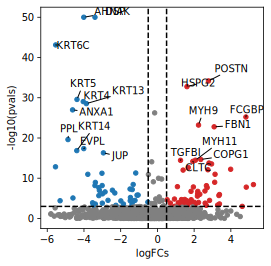

/tmp/ipykernel_4166386/3507434027.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [6]:
set_matplotlib_formats('svg')
dc.plot_volcano_df(df_NE_vs_M.set_index('gene'), x='log2fc', y='Pvalue_clipped', sign_thr=0.001, top=20, lFCs_limit=6, figsize=(4,4), save=f'{plotfolder}/volcano.svg')
plt.show()
set_matplotlib_formats('png')

# sc

In [7]:
genes_up = sorted(df_NE_vs_M.query('qvalue<0.001 and log2fc>0.58').gene.values)
genes_down = sorted(df_NE_vs_M.query('qvalue<0.001 and log2fc<-0.58').gene.values)

In [8]:
" ".join(genes_up)

'ACTN4 AGR2 ATP1A1 CLTC COL4A1 COL4A2 COPA COPG1 EEF1A1 EMILIN1 EPX ETHE1 FBN1 FCGBP FLNA HSP90B1 HSPG2 IGHA2 KRT2 KRT9 LAMA5 LAMB1 LAMC1 LGALS3 LGALS4 LRPPRC MDH2 MUC2 MYH11 MYH9 MYO1D PLS1 POSTN PRG2 QARS1 SND1 TGFBI TLN1 VPS51'

In [9]:
" ".join(genes_down) 

'AHNAK ANXA1 APOB CAMK2D COL7A1 CRYBG1 CTNND1 DES DSC2 DSG1 DSP ECM1 EPPK1 EVPL FAM83H FLNC HSPB1 JUP KRT1 KRT13 KRT14 KRT15 KRT16 KRT17 KRT19 KRT4 KRT5 KRT6A KRT6B KRT6C KRT77 KRT78 KRT80 NES PKP3 PPL S100A11 SPTB SPTBN2 TUBA4A TUBB6'

# Analysis

In [10]:
ECM_diagnosis = ["NE", "M"]

/users/mstrasse/CRUK-code/crukiopy/celltype_mappings.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/users/mstrasse/CRUK-code/crukiopy/celltype_mappings.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_4166386/509737976.py:5: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.


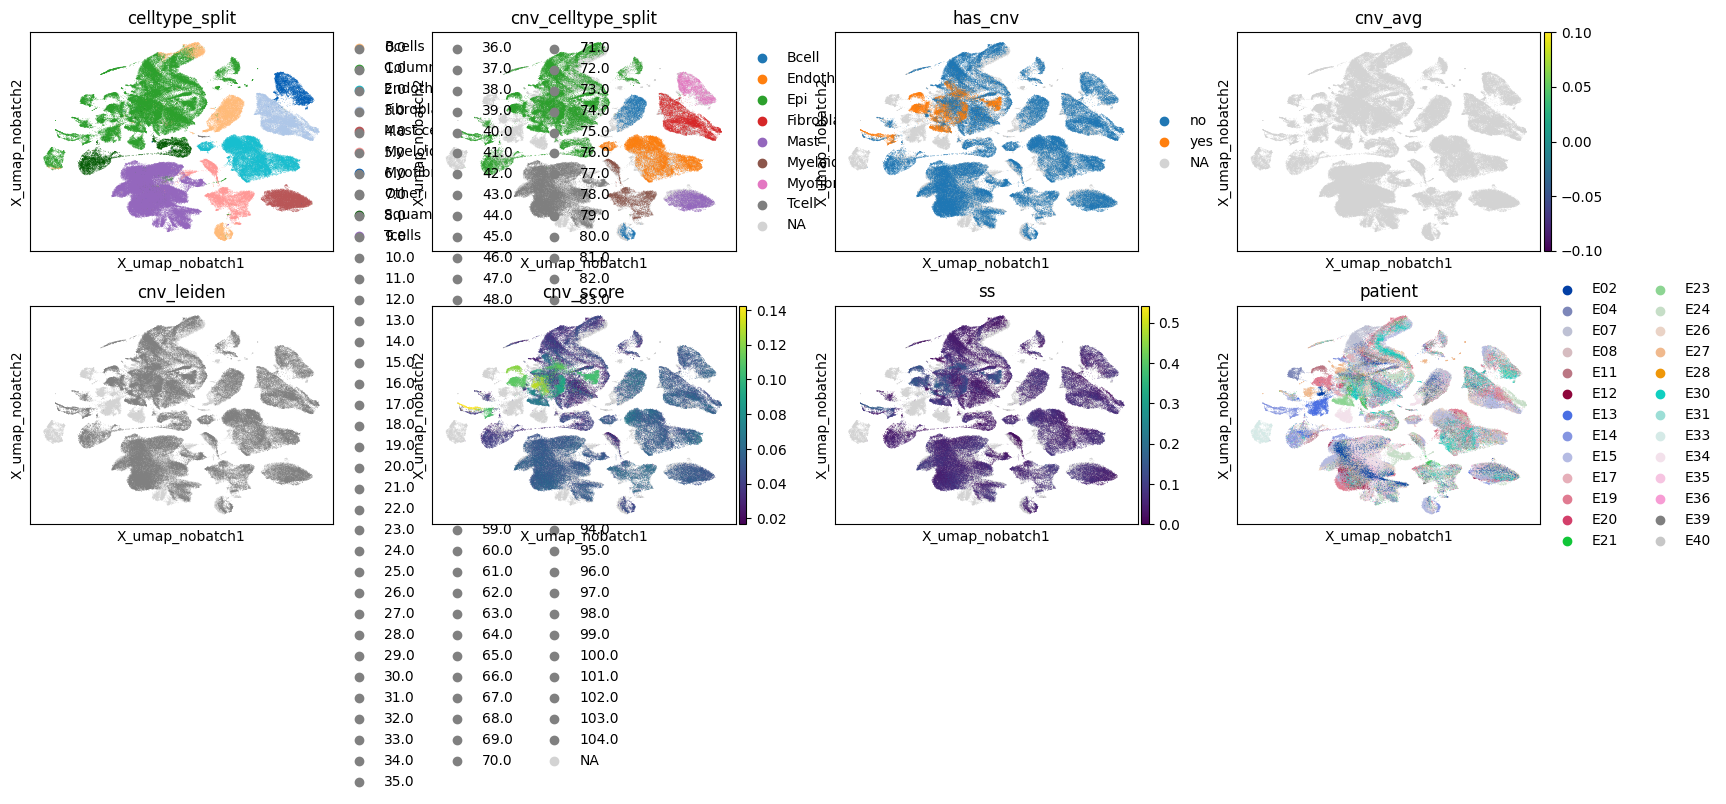

In [11]:
from revision_utils import load_merged_data
A = load_merged_data()

# add CNV calls
df_cnv = pd.read_csv('/users/mstrasse/CRUK-code/notebooks/CNVs/O_full.csv', index_col=0)
A.obs.index = A.obs.index.map(lambda x: '-'.join(x.split('-')[:2]))
A.obs = A.obs.merge(df_cnv[['cnv_celltype_split','has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss']], left_index=True, right_index=True, how='left')
A.obs.cnv_leiden = pd.Categorical(A.obs.cnv_leiden)

sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

In [12]:
ECM_patients = ["E04","E14","E20", "E21","E24"]

In [13]:
A = A[A.obs.patient.isin(ECM_patients)]
A = A[A.obs.diagnosis.isin(ECM_diagnosis)].copy()
A.obs.drop(['nobatch_louvain', 'louvain'], axis=1, inplace=True)
A = A.raw.to_adata()
A.raw = A

In [14]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
    'Other'
]

A.obs.celltype_split = pd.Categorical(A.obs.celltype_split, cluster_order)

In [15]:
# recolor(A, 'celltype_split', color_dict_coarse_celltype)

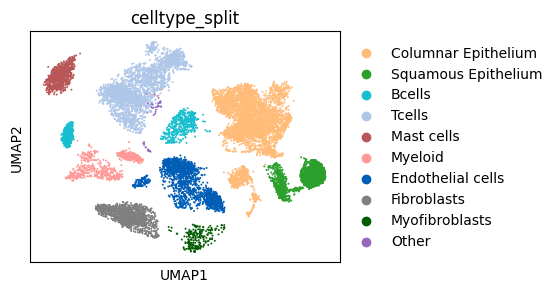

In [16]:
sc.pl.umap(A, color='celltype_split')

In [17]:
A.obs['celltype_split_cnv_augmented'] = A.obs['celltype_split'].astype(str)
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="yes"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV+)"
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="no"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV-)"

_c = ['Columnar Epithelium (CNV-)', 'Columnar Epithelium (CNV+)', 'Squamous Epithelium', 'Bcells', 'Tcells', 'Mast cells', 'Myeloid', 'Endothelial cells', 'Fibroblasts',  'Myofibroblasts', 'Other']
A.obs.celltype_split_cnv_augmented = pd.Categorical(A.obs.celltype_split_cnv_augmented, _c) 

pd.crosstab(A.obs.celltype_split_cnv_augmented, A.obs.has_cnv)

has_cnv                         no  yes
celltype_split_cnv_augmented           
Columnar Epithelium (CNV-)    4209    0
Columnar Epithelium (CNV+)       0  432
Squamous Epithelium           2244   11
Bcells                         586    0
Tcells                        2318    0
Mast cells                     628    0
Myeloid                        678    0
Endothelial cells             1501    0
Fibroblasts                   1171    0
Myofibroblasts                 214    0
Other                           34    0

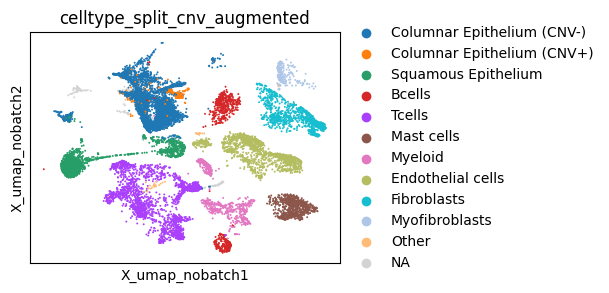

In [18]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split_cnv_augmented'])

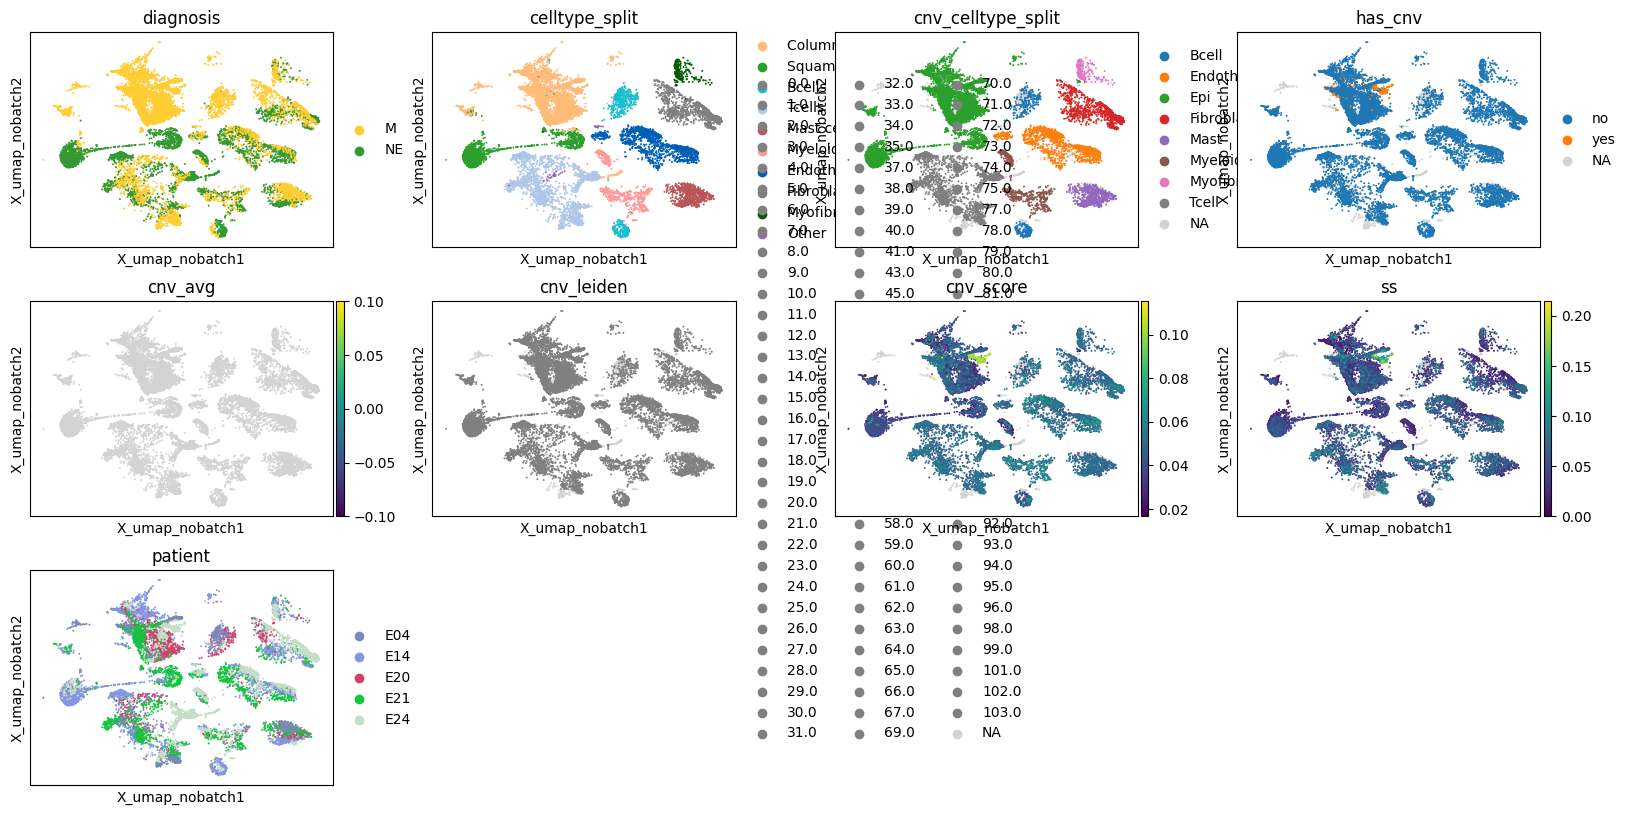

In [19]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['diagnosis', 'celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

# NE vs M differential expression

## ECM-DE vs clusters

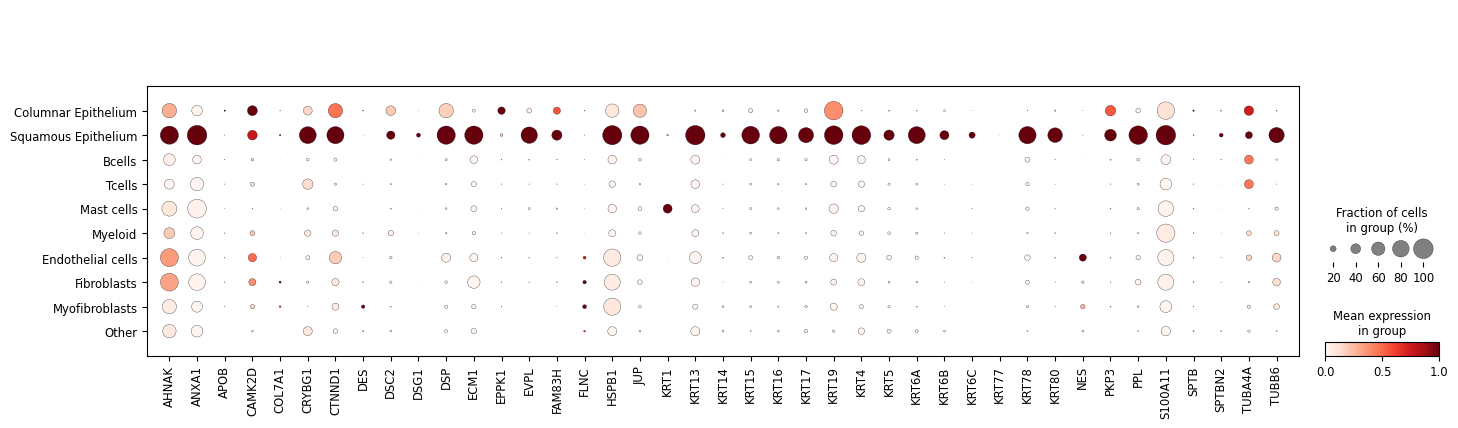

In [20]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

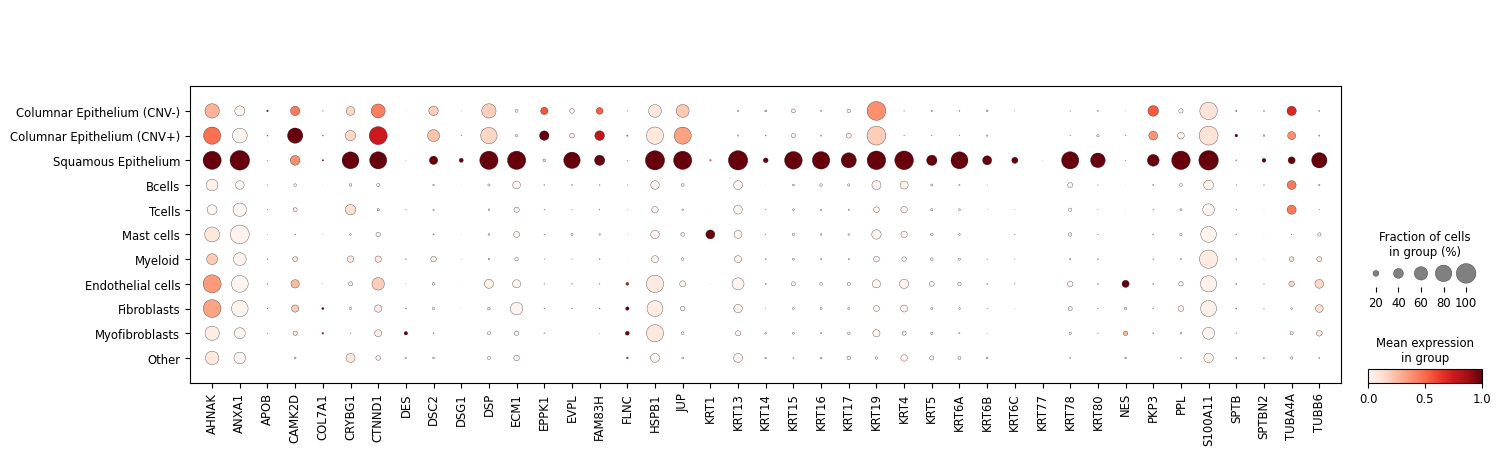

In [21]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

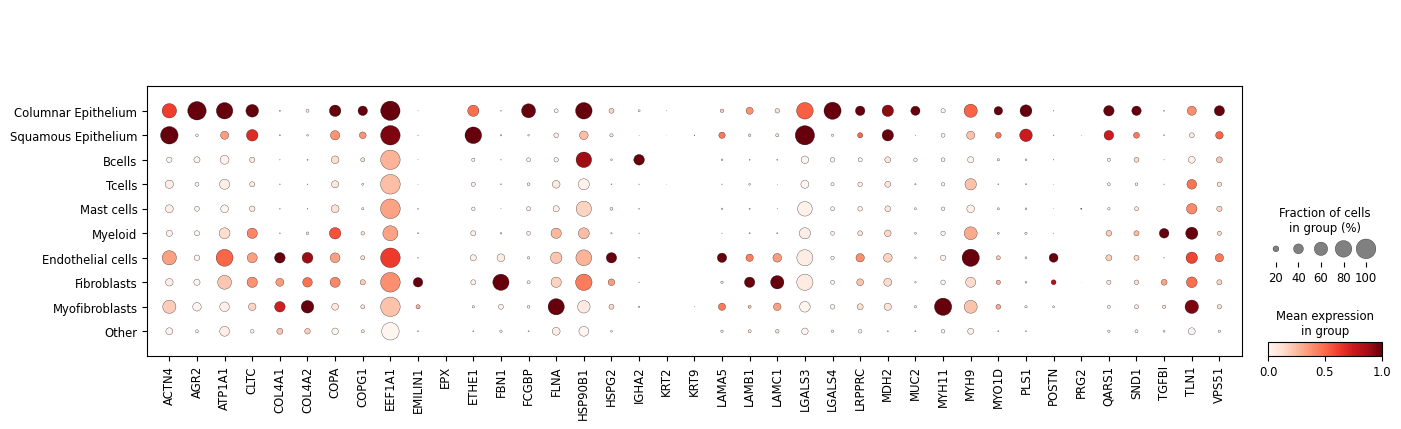

In [22]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

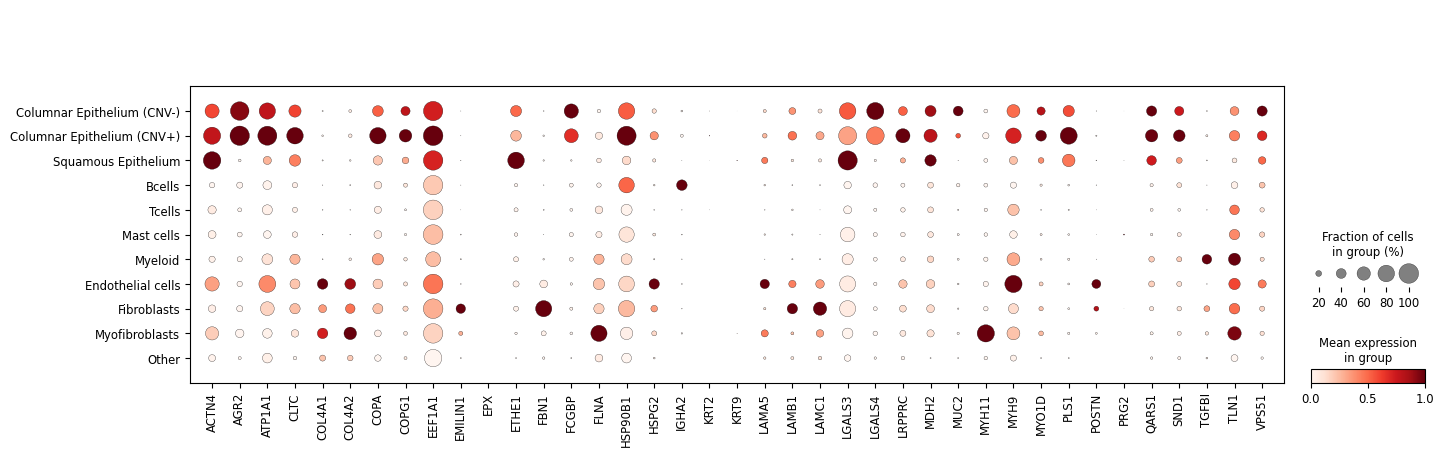

In [23]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

In [24]:
_d = A.obs.groupby(['celltype_split_cnv_augmented','diagnosis']).samplename.count().reset_index().rename({'samplename': 'n_cells'}, axis=1)
celltype_total = _d .groupby('celltype_split_cnv_augmented').n_cells.sum().to_dict()
_d['total'] = _d.celltype_split_cnv_augmented.apply(lambda x: celltype_total[x]).astype(int)
_d['percent_cells'] = _d.n_cells / _d.total
# reverse order so it works in the flipped diagram
_d['celltype_split_cnv_augmented'] = pd.Categorical(_d['celltype_split_cnv_augmented'] , _d['celltype_split_cnv_augmented'].cat.categories[::-1])
_d.head()

/tmp/ipykernel_4166386/1318121404.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_4166386/1318121404.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


celltype_split_cnv_augmented diagnosis  n_cells  total  percent_cells
0   Columnar Epithelium (CNV-)         M     4165   4209       0.989546
1   Columnar Epithelium (CNV-)        NE       44   4209       0.010454
2   Columnar Epithelium (CNV+)         M      432    432       1.000000
3   Columnar Epithelium (CNV+)        NE        0    432       0.000000
4          Squamous Epithelium         M       83   2256       0.036791

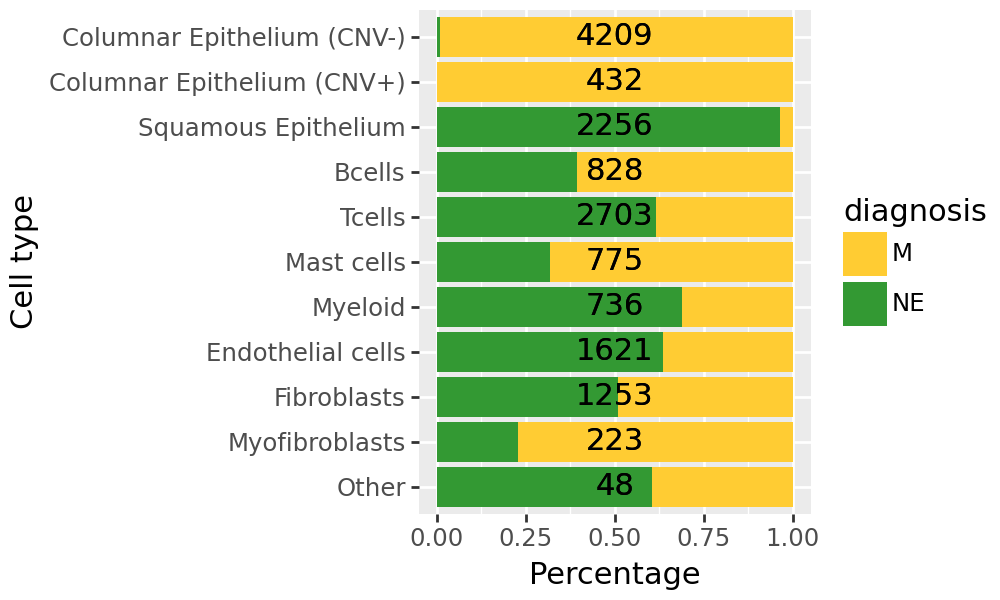

In [25]:
pn.ggplot(_d) +pn.aes(x='celltype_split_cnv_augmented', fill='diagnosis', y='percent_cells') + pn.geom_bar(stat='identity') \
+ pn.geom_text(data=_d, mapping=pn.aes( x='celltype_split_cnv_augmented', y=0.5, label='total')) \
+ pn.coord_flip()+pn.theme(figure_size=(5,3)) + pn.labs(y='Percentage', x='Cell type') + pn.scale_fill_manual(color_dict_diagnosis)

# General fold change in proteomics vs scrnaseq 
independent of cell type etc

In [26]:
from ecm_tools import fold_change_pseudobulk_fixed
import decoupler as dc

adata_bulk_de = dc.get_pseudobulk(
        A,
        sample_col='samplename', 
        groups_col=None,
        use_raw=False,
        mode='sum',
        min_cells=0,
        # min_counts=10000,
    )
adata_bulk_de.raw  = adata_bulk_de

In [27]:
_FC_pseudobulk_df =  fold_change_pseudobulk_fixed(adata_bulk_de, gene_list=genes_up+genes_down, diagnosis1="NE", diagnosis2="M")
_FC_pseudobulk_df.shape

 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                    | 34/80 [00:00<00:00, 162.85it/s]

EPX not in scRNAseq. skipping


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 164.01it/s]


(79, 6)

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison.svg


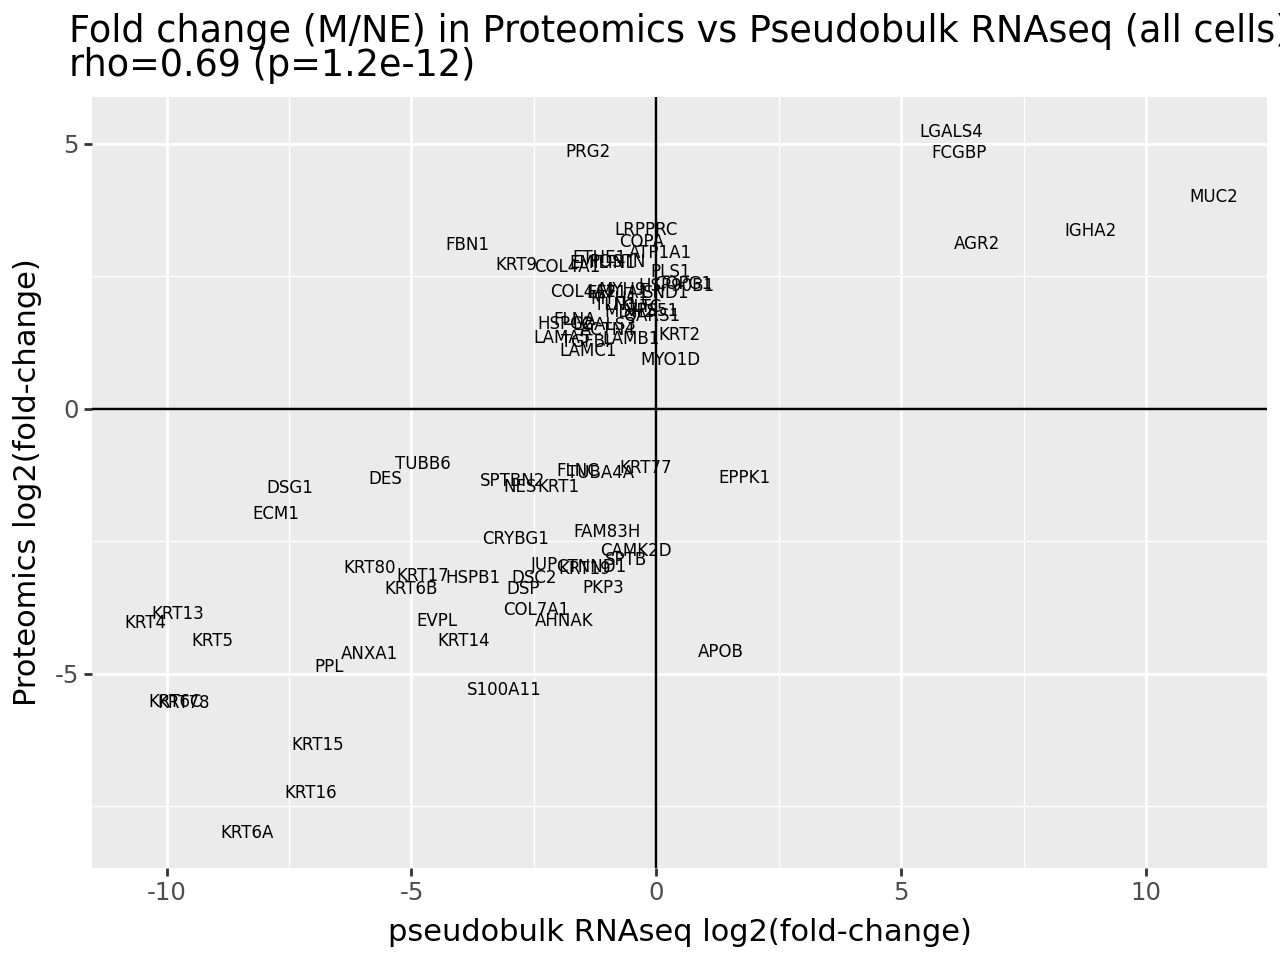

In [28]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_NE_vs_M.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene')#\

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)


p = pn.ggplot(df_FC_sc_proteomics,
          pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' ))\
+ pn.geom_text(size=6) + pn.geom_vline(xintercept=0) + pn.geom_hline(yintercept=0)\
+ pn.labs(title=f'Fold change (M/NE) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
p.save(f'{plotfolder}/ECM_FC_comparison.svg')
p

In [29]:
df_FC_sc_proteomics.query('gene=="POSTN"')

index  delta_expression_scrnaseq  NE_expression_scrnaseq  \
31     31                  -603458.5               1422421.0   

    T_expression_scrnaseq  ratio_scrnaseq   gene  log2fc_proteomics  \
31               818962.5        0.575753  POSTN               2.78   

    qvalue_proteomics Comparison (group1/group2)  # of Ratios        Pvalue  \
31       1.750000e-32                    M / MaN          355  6.710000e-35   

   up_or_down  Pvalue_clipped  
31         up    6.710000e-35

## Using Deseq to get FCs

In [30]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [31]:
pdata = dc.get_pseudobulk(A.raw.to_adata(),
                          sample_col='samplename',
                          groups_col='diagnosis',#'celltype_split',
                          # layer='counts',
                          mode='sum',
                          min_cells=50,
                          # min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 10 × 28584
    obs: 'samplename', 'diagnosis', 'sample_diagnosis', 'patient', 'treatment', 'procedure', 'dataset', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename'
    layers: 'psbulk_props'

### ACtual DE
#### with patient 

In [32]:
dds = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['patient','diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds.deseq2()

stats_res = DeseqStats(dds, contrast=["diagnosis",  "M", "NE"])
stats_res.summary()
df_DE= stats_res.results_df


stats_res = DeseqStats(dds, contrast=["diagnosis",  "M", "NE"])
stats_res.summary()
stats_res.lfc_shrink(coeff='diagnosis_NE_vs_M')
df_DE_shrink= stats_res.results_df

# somehow the lfc is the wrong way around
df_DE_shrink.log2FoldChange = -df_DE_shrink.log2FoldChange

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 5.70 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 9.01 seconds.

Fitting LFCs...
... done in 7.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.57 seconds.



Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.512406  0.240782 -2.128091  3.332950e-02   
A1CF     295.555810        3.855983  0.582992  6.614130  3.737438e-11   
A2M     2078.610044       -1.246957  0.677812 -1.839680  6.581527e-02   
A2ML1   1375.392936       -5.476074  0.602493 -9.089022  9.993356e-20   
A2MP1     10.599266       -0.953732  0.617588 -1.544285  1.225192e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.350902  0.363308 -0.965851  3.341190e-01   
ZYG11B   444.263504       -0.164399  0.174463 -0.942315  3.460315e-01   
ZYX      692.997782        0.203911  0.349980  0.582637  5.601375e-01   
ZZEF1    396.206606        0.577632  0.348697  1.656542  9.761212e-02   
ZZZ3     300.004867        0.235866  0.231542  1.018672  3.083588e-01   

                padj  
A1BG    1.220277e-01  
A1CF    1.746842e-09 

Running Wald tests...
... done in 2.03 seconds.



Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.512406  0.240782 -2.128091  3.332950e-02   
A1CF     295.555810        3.855983  0.582992  6.614130  3.737438e-11   
A2M     2078.610044       -1.246957  0.677812 -1.839680  6.581527e-02   
A2ML1   1375.392936       -5.476074  0.602493 -9.089022  9.993356e-20   
A2MP1     10.599266       -0.953732  0.617588 -1.544285  1.225192e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.350902  0.363308 -0.965851  3.341190e-01   
ZYG11B   444.263504       -0.164399  0.174463 -0.942315  3.460315e-01   
ZYX      692.997782        0.203911  0.349980  0.582637  5.601375e-01   
ZZEF1    396.206606        0.577632  0.348697  1.656542  9.761212e-02   
ZZZ3     300.004867        0.235866  0.231542  1.018672  3.083588e-01   

                padj  
A1BG    1.220277e-01  
A1CF    1.746842e-09 

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: diagnosis NE vs M
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564        0.463063  0.241061 -2.128091  3.332950e-02   
A1CF     295.555810       -3.649401  0.649298  6.614130  3.737438e-11   
A2M     2078.610044        0.664905  0.738183 -1.839680  6.581527e-02   
A2ML1   1375.392936        5.355716  0.668253 -9.089022  9.993356e-20   
A2MP1     10.599266        0.584110  0.669346 -1.544285  1.225192e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701        0.270825  0.394954 -0.965851  3.341190e-01   
ZYG11B   444.263504        0.153096  0.177295 -0.942315  3.460315e-01   
ZYX      692.997782       -0.156979  0.382136  0.582637  5.601375e-01   
ZZEF1    396.206606       -0.464060  0.372880  1.656542  9.761212e-02   
ZZZ3     300.004867       -0.211386  0.233612  1.018672  3.083588e-01   

                padj  
A1BG    1.220277e-01  
A1CF    1.7468

... done in 4.47 seconds.



#### Without patient

In [33]:
dds_diag_only = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds_diag_only.deseq2()

stats_res_diag_only = DeseqStats(dds_diag_only, contrast=["diagnosis",  "M", "NE"])
stats_res_diag_only.summary()
df_DE_diag_only= stats_res_diag_only.results_df

stats_res_diag_only = DeseqStats(dds_diag_only, contrast=["diagnosis",  "M", "NE"])
stats_res_diag_only.summary()
stats_res_diag_only.lfc_shrink(coeff='diagnosis_NE_vs_M')
df_DE_diag_only_shrink= stats_res_diag_only.results_df

# lfc are the wring way around
df_DE_diag_only_shrink.log2FoldChange = -df_DE_diag_only_shrink.log2FoldChange

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.68 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 5.77 seconds.

Fitting LFCs...
... done in 4.14 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 565 outlier genes.

Fitting dispersions...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.14 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Running Wald tests...
... done in 5.95 seconds.



Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.024269  0.385816 -0.062903  9.498439e-01   
A1CF     295.555810        4.006286  0.615563  6.508325  7.599318e-11   
A2M     2078.610044       -0.832804  0.699687 -1.190252  2.339474e-01   
A2ML1   1375.392936       -5.932452  0.739155 -8.025994  1.007069e-15   
A2MP1     10.599266       -0.064700  0.773536 -0.083641  9.333416e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.575581  0.347423 -1.656716  9.757699e-02   
ZYG11B   444.263504       -0.315010  0.171319 -1.838738  6.595378e-02   
ZYX      692.997782       -0.010445  0.297192 -0.035145  9.719644e-01   
ZZEF1    396.206606        0.851884  0.424098  2.008694  4.456961e-02   
ZZZ3     300.004867        0.259307  0.179161  1.447345  1.478003e-01   

                padj  
A1BG    9.781284e-01  
A1CF    5.292407e-09 

Running Wald tests...
... done in 2.53 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.024269  0.385816 -0.062903  9.498439e-01   
A1CF     295.555810        4.006286  0.615563  6.508325  7.599318e-11   
A2M     2078.610044       -0.832804  0.699687 -1.190252  2.339474e-01   
A2ML1   1375.392936       -5.932452  0.739155 -8.025994  1.007069e-15   
A2MP1     10.599266       -0.064700  0.773536 -0.083641  9.333416e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.575581  0.347423 -1.656716  9.757699e-02   
ZYG11B   444.263504       -0.315010  0.171319 -1.838738  6.595378e-02   
ZYX      692.997782       -0.010445  0.297192 -0.035145  9.719644e-01   
ZZEF1    396.206606        0.851884  0.424098  2.008694  4.456961e-02   
ZZZ3     300.004867        0.259307  0.179161  1.447345  1.478003e-01   

                padj  
A1BG    9.781284e-01  
A1CF    5.292407e-09 

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + s

Shrunk log2 fold change & Wald test p-value: diagnosis NE vs M
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564    3.065959e-07  0.001225 -0.062903  9.498439e-01   
A1CF     295.555810   -3.807753e+00  0.644344  6.508325  7.599318e-11   
A2M     2078.610044    2.108524e-06  0.001355 -1.190252  2.339474e-01   
A2ML1   1375.392936    5.758383e+00  0.730840 -8.025994  1.007069e-15   
A2MP1     10.599266    1.164107e-07  0.001246 -0.083641  9.333416e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701    5.220823e-06  0.001315 -1.656716  9.757699e-02   
ZYG11B   444.263504    1.159780e-05  0.001269 -1.838738  6.595378e-02   
ZYX      692.997782    1.948809e-07  0.001222 -0.035145  9.719644e-01   
ZZEF1    396.206606   -4.304278e-06  0.001137  2.008694  4.456961e-02   
ZZZ3     300.004867   -8.150068e-06  0.001201  1.447345  1.478003e-01   

                padj  
A1BG    9.781284e-01  
A1CF    5.2924

... done in 4.91 seconds.



## Plots

In [34]:
from ecm_tools import plot_fc_comparision

### Interlude
FCs are problematic to compare (shrinkage vs no-shrinkage, noisy etc).
How about a more clearcut comparison:

For all genes measured in ECM and scRNAseq:
- how many were DE in each technology and whats the overlap -> Fisher test
- of the ones that are DEG in both technologies, how many are cocordant (genes goes up in both ECM and sc, gene does doewn in both ECM and sc)?

In [35]:
from scipy.stats import fisher_exact
from sklearn.metrics import accuracy_score

In [36]:
df_tmp = df_DE.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True)

In [37]:
threshold = 0.05
table = pd.crosstab(
    df_tmp.padj < threshold, 
    df_tmp.qvalue < threshold
)
print(fisher_exact(table))
table

SignificanceResult(statistic=1.964956195244055, pvalue=1.1410353423163237e-05)


qvalue  False  True 
padj                
False     942    153
True      282     90

In [38]:
d2 = df_tmp.query('padj < @threshold and qvalue < @threshold')

table = pd.crosstab(
    d2.log2FoldChange < 0, 
    d2.log2fc < 0
)
print(fisher_exact(table))
table

SignificanceResult(statistic=76.14285714285714, pvalue=8.621862010814601e-15)


log2fc          False  True 
log2FoldChange              
False              39      7
True                3     41

In [39]:
#up in sc, down in ECM 
df_tmp.query('padj < @threshold and qvalue < @threshold and log2FoldChange>0 and log2fc<0')

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ACSL5      569.294816        2.284104  0.448436  5.093495  3.515232e-07   
ATP2A3     739.863970        1.872002  0.423107  4.424417  9.670293e-06   
ATP5F1B   4183.937559        0.535979  0.153973  3.480986  4.995719e-04   
DYNC1LI2  1102.643918        0.474687  0.141436  3.356187  7.902514e-04   
EPPK1      297.162244        2.610128  0.465112  5.611829  2.001995e-08   
IMMT       626.498491        0.794755  0.190820  4.164947  3.114253e-05   
UQCRC2    1644.836081        0.672093  0.231207  2.906883  3.650493e-03   

                  padj  log2fc    qvalue Comparison (group1/group2)  \
ACSL5     8.306089e-06   -0.05  0.044900                    M / MaN   
ATP2A3    1.618444e-04   -3.48  0.049300                    M / MaN   
ATP5F1B   4.839887e-03   -0.90  0.008910                    M / MaN   
DYNC1LI2  7.059948e-03   -4.06  0.037800                    M / MaN   
EPPK1     6.003792e-07   -1.30  0.000526                    M / MaN   
IMMT      4.514254e-04   -1.37  0.045500                    M / MaN   
UQCRC2    2.402280e-02   -2.19  0.028100                    M / MaN   

          # of Ratios    Pvalue up_or_down  Pvalue_clipped  
ACSL5              45  0.010400     nonsig        0.010400  
ATP2A3             10  0.012200     nonsig        0.012200  
ATP5F1B           125  0.001150     nonsig        0.001150  
DYNC1LI2           35  0.008080     nonsig        0.008080  
EPPK1             430  0.000044       down        0.000044  
IMMT               30  0.010700     nonsig        0.010700  
UQCRC2             50  0.005480     nonsig        0.005480

In [40]:
df_tmp.query('padj < @threshold and qvalue < @threshold and log2FoldChange<0 and log2fc>0')

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AHNAK2   252.142585       -3.427425  0.497863 -6.884274  5.808299e-12   
COL6A2  1157.803077       -1.794881  0.467448 -3.839744  1.231628e-04   
COL6A3  1377.990534       -1.623098  0.572520 -2.835006  4.582484e-03   

                padj  log2fc        qvalue Comparison (group1/group2)  \
AHNAK2  2.944562e-10    0.36  3.510000e-02                    M / MaN   
COL6A2  1.485317e-03    0.34  6.510000e-03                    M / MaN   
COL6A3  2.857603e-02    0.06  2.950000e-09                    M / MaN   

        # of Ratios        Pvalue up_or_down  Pvalue_clipped  
AHNAK2           55  7.380000e-03     nonsig    7.380000e-03  
COL6A2          235  7.930000e-04     nonsig    7.930000e-04  
COL6A3          980  1.020000e-10     nonsig    1.020000e-10

~patient + diag, unshrubk

In [41]:
all_genes = [_ for _ in genes_up+genes_down if _ in df_DE.index.values]
len(all_genes), len(genes_up+genes_down)

(79, 80)

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_unshrunk_patient_diag.svg


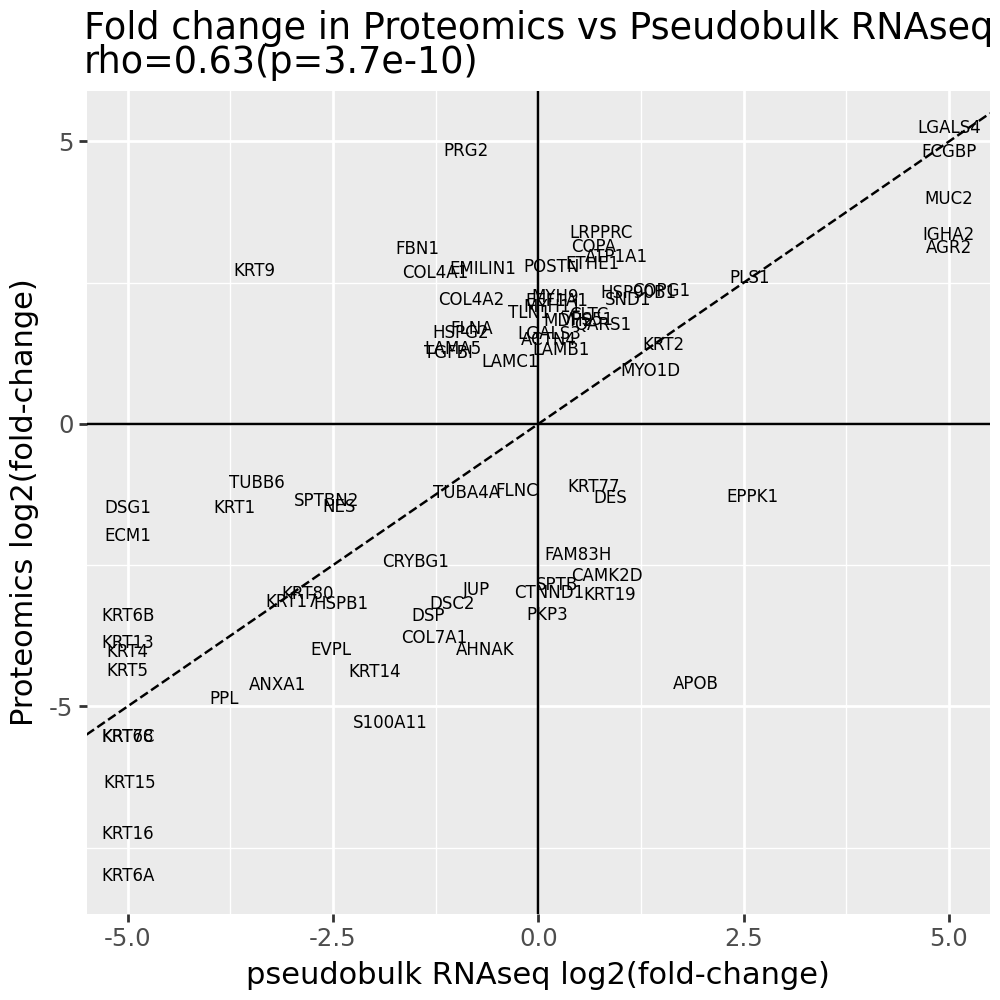

In [42]:
df = df_DE.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df, ) + pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_patient_diag.svg')

p

~patient + diag, with shrinkage

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_shrunk_patient_diag.svg


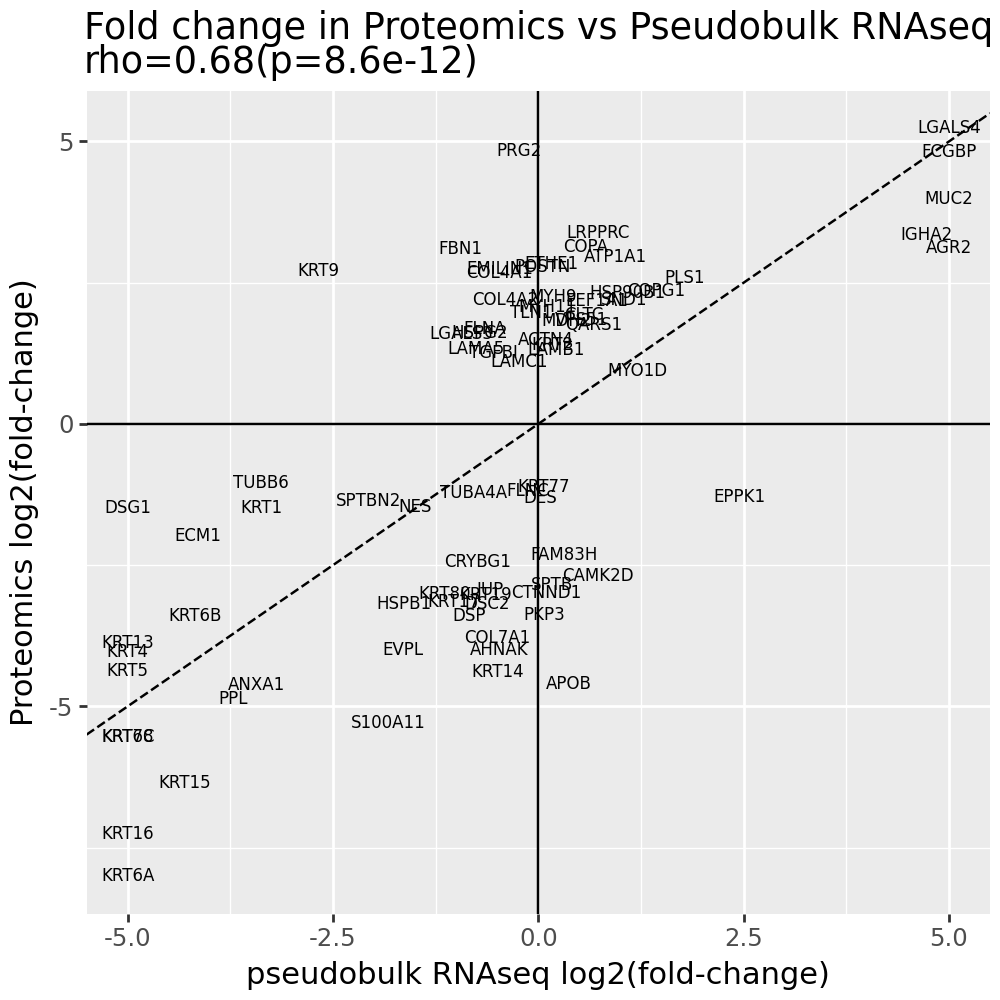

In [43]:
df = df_DE_shrink.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_patient_diag.svg')
p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_unshrunk_diag.svg


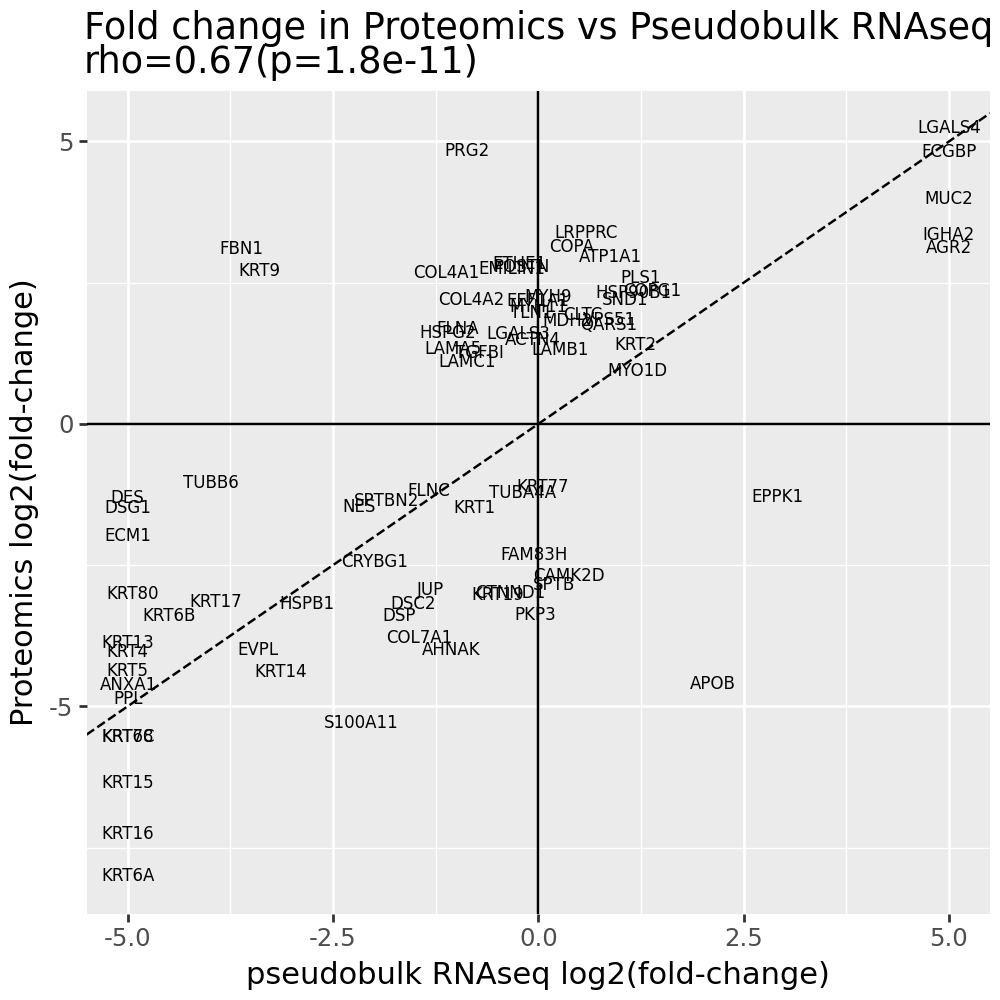

In [44]:
df = df_DE_diag_only.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_diag.svg')
p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_unshrunk_diag.svg


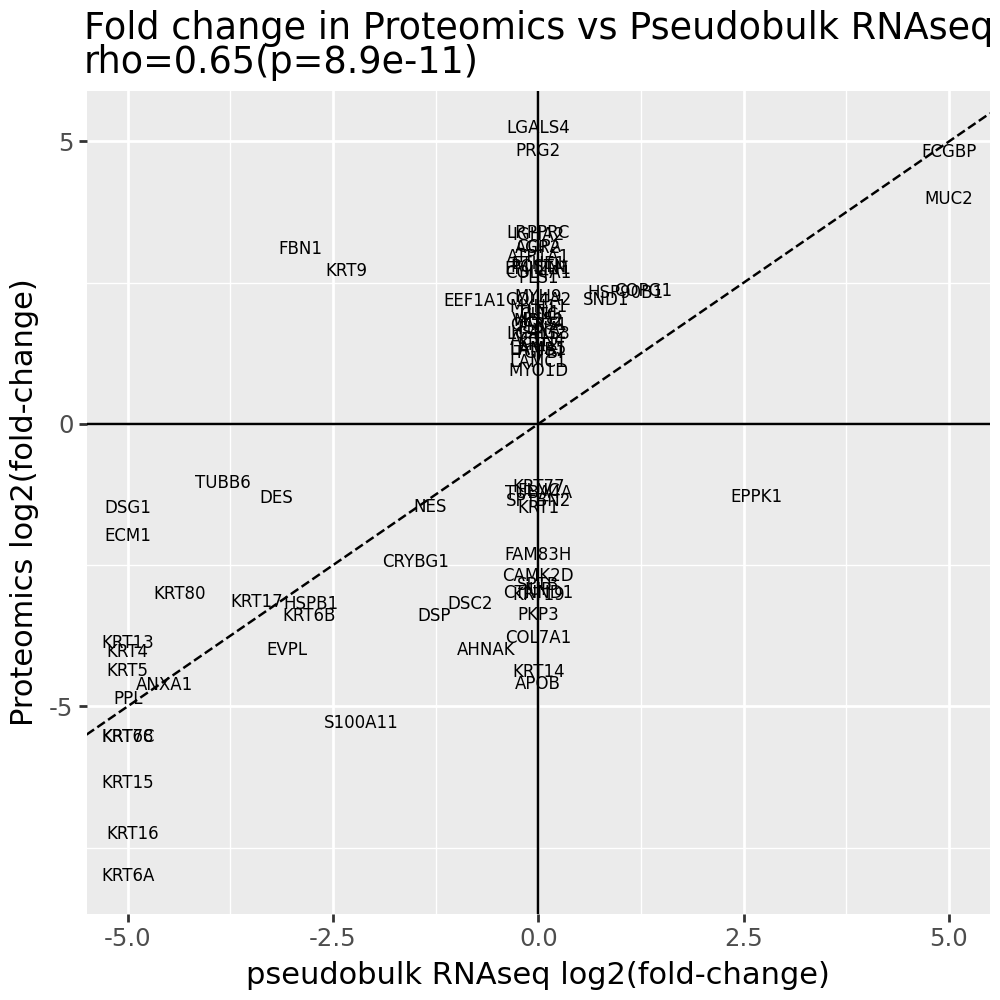

In [45]:
df = df_DE_diag_only_shrink.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_diag.svg')
p

# Fold change by cell type

In [46]:
from ecm_tools import suis_plot_fixed, ecm_lfc_via_deseq_python

## Naive fold changes

In [47]:
_new_df = suis_plot_fixed(genes_up, A, diagnosis1="NE", diagnosis2="M")
_new_df['delta_expression_trim'] = _new_df['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df['min_cells'] =  _new_df.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df['ratio_cells'] =  _new_df.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.07it/s]


In [48]:
_new_df_down = suis_plot_fixed(genes_down, A, diagnosis1="NE", diagnosis2="M")
_new_df_down['delta_expression_trim'] = _new_df_down['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df_down['min_cells'] =  _new_df_down.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df_down['ratio_cells'] =  _new_df_down.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  7.01it/s]


In [49]:
# colormap = pn.scale_color_brewer(type='qual', palette="Paired", name='Cell type') 
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_per_celltype_up_old.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 39 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 39 rows containing missing values.


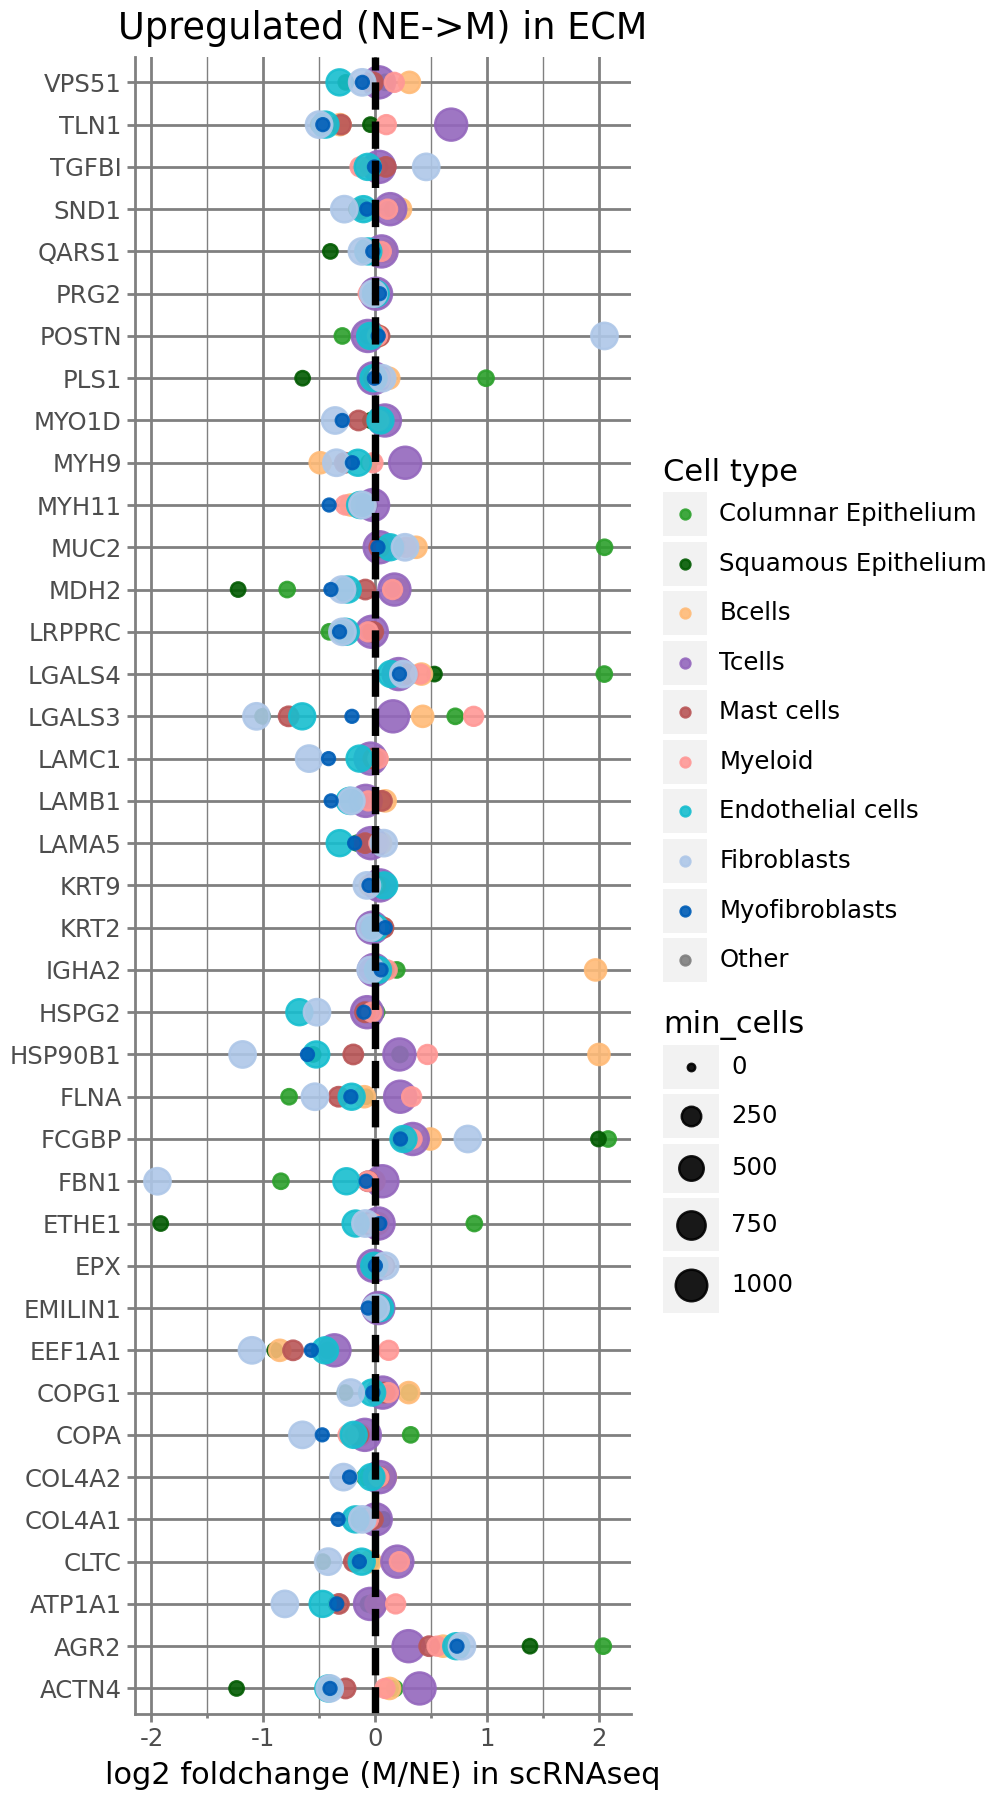

In [50]:
p = pn.ggplot(_new_df.merge(df_NE_vs_M, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap+ pn.geom_vline(xintercept=0, size=1.5, linetype="dashed") \
+ pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_up_old.svg')

p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_per_celltype_down_old.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 41 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 41 rows containing missing values.


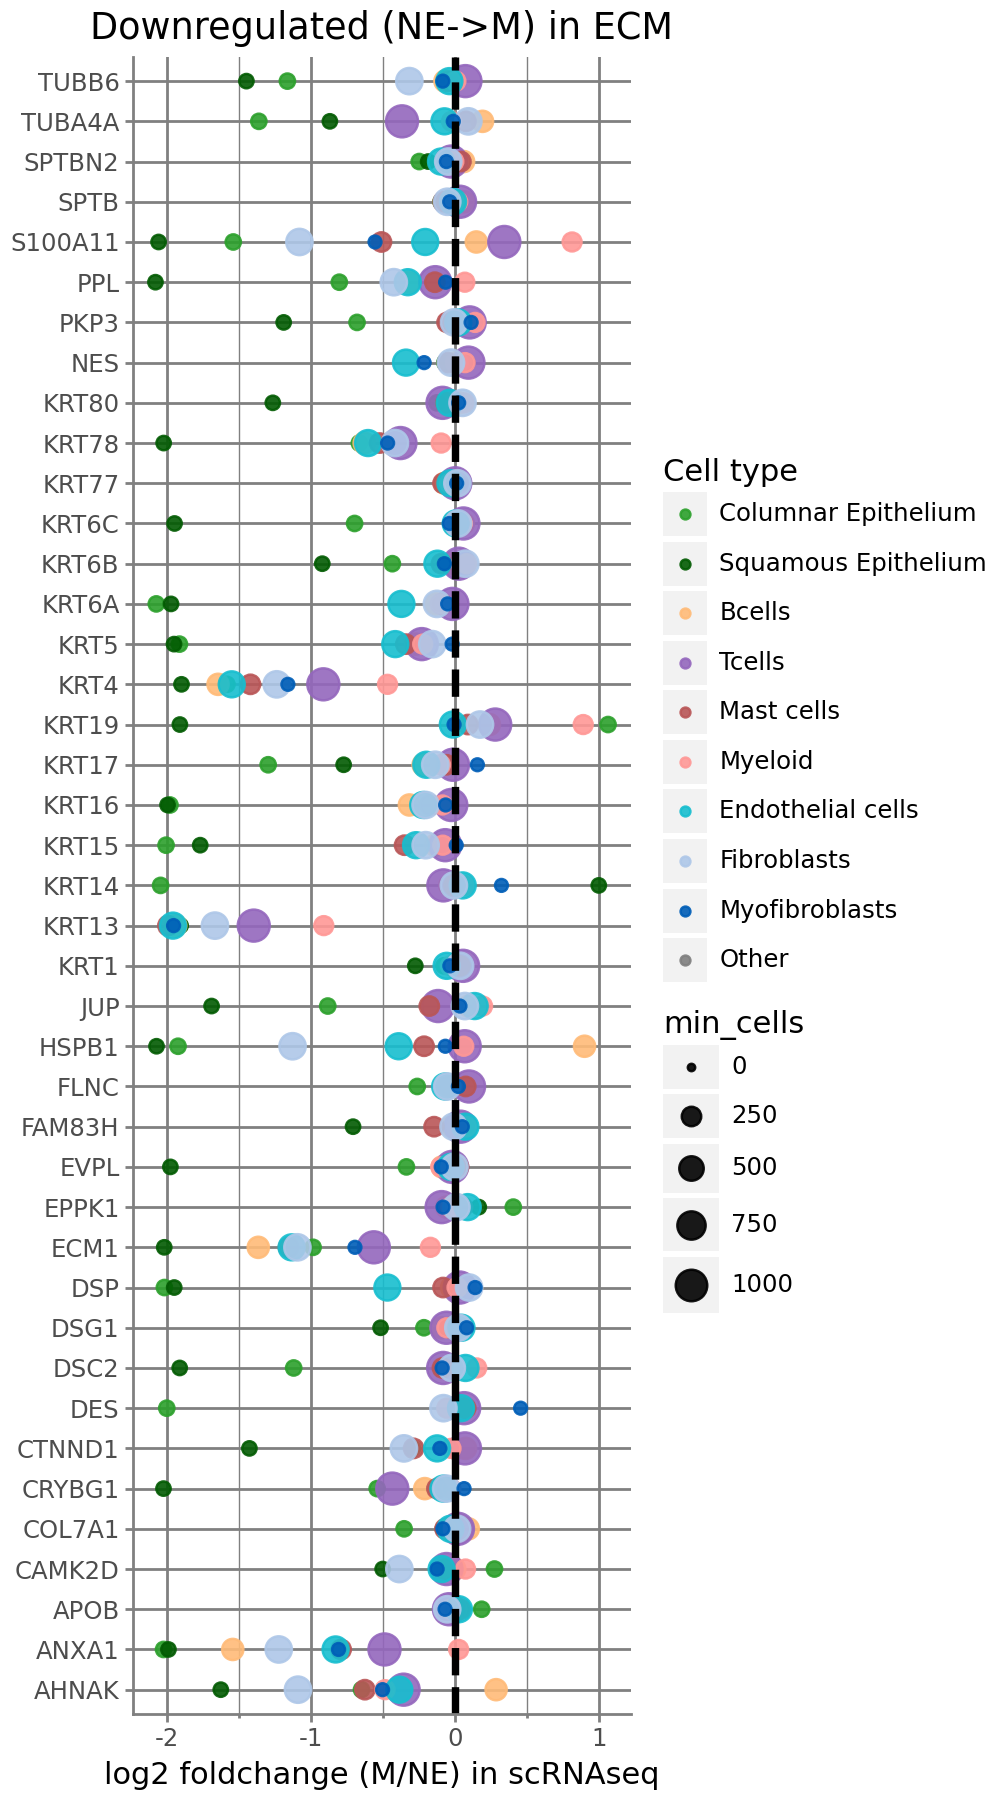

In [51]:
p = pn.ggplot(_new_df_down.merge(df_NE_vs_M, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap + pn.geom_vline(xintercept=0, size=1.5, linetype="dashed") \
+ pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_down_old.svg')
p

## DEseq fold changes
A general problem seems to be very low abundance, but still DE, probably due to ambient RNA. Lets filter out low abundance

In [52]:
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis, ['NE','M'])

In [53]:
A.obs['celltype_merge_epi']=A.obs['celltype_split'].astype(str)
A.obs['celltype_merge_epi'].replace({'Columnar Epithelium': 'Epithelium','Squamous Epithelium': "Epithelium"}, inplace=True)

In [54]:
from ecm_tools import the_plot_shrunk, the_plot_unshrunk, ecm_lfc_via_deseq_python

### ~patient+diagnosis

In [55]:
contrast = ["diagnosis",  "NE", "M"]
design_factors = ['patient','diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.20 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 2.97 seconds.

Fitting LFCs...
... done in 2.97 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.19 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.37 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 4.67 seconds.

Fitting LFCs...
... done in 4.01 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 3.17 seconds.



Celltype: Mast cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.31 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.40 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Fit type used for VST : parametric


Fitting dispersions...
... done in 1.89 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.53 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 3.02 seconds.

Fitting LFCs...
... done in 2.67 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size

Fit type used for VST : parametric


Fitting dispersions...
... done in 2.79 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.37 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 1.15 seconds.

Fitting LFCs...
... done in 1.28 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarn

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.96 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.62 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 3.21 seconds.

Fitting LFCs...
... done in 2.87 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarn

Fit type used for VST : parametric


Fitting dispersions...
... done in 2.03 seconds.



Celltype: Myeloid


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.27 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 3.09 seconds.

Fitting LFCs...
... done in 4.44 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.87 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.26 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.23 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.01 seconds.

Fitting LFCs...
... done in 2.16 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning

Fit type used for VST : parametric


Fitting dispersions...
... done in 2.33 seconds.



Celltype: Other


In [56]:
df_de_all.celltype.unique()

array(['Tcells', 'Epithelium', 'Mast cells', 'Fibroblasts',
       'Myofibroblasts', 'Endothelial cells', 'Myeloid', 'Bcells'],
      dtype=object)

/tmp/ipykernel_4166386/1843809452.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='baseMean', ylabel='Density'>

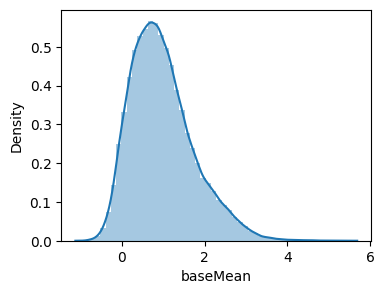

In [57]:
sns.distplot(np.log10(df_de_all.baseMean))

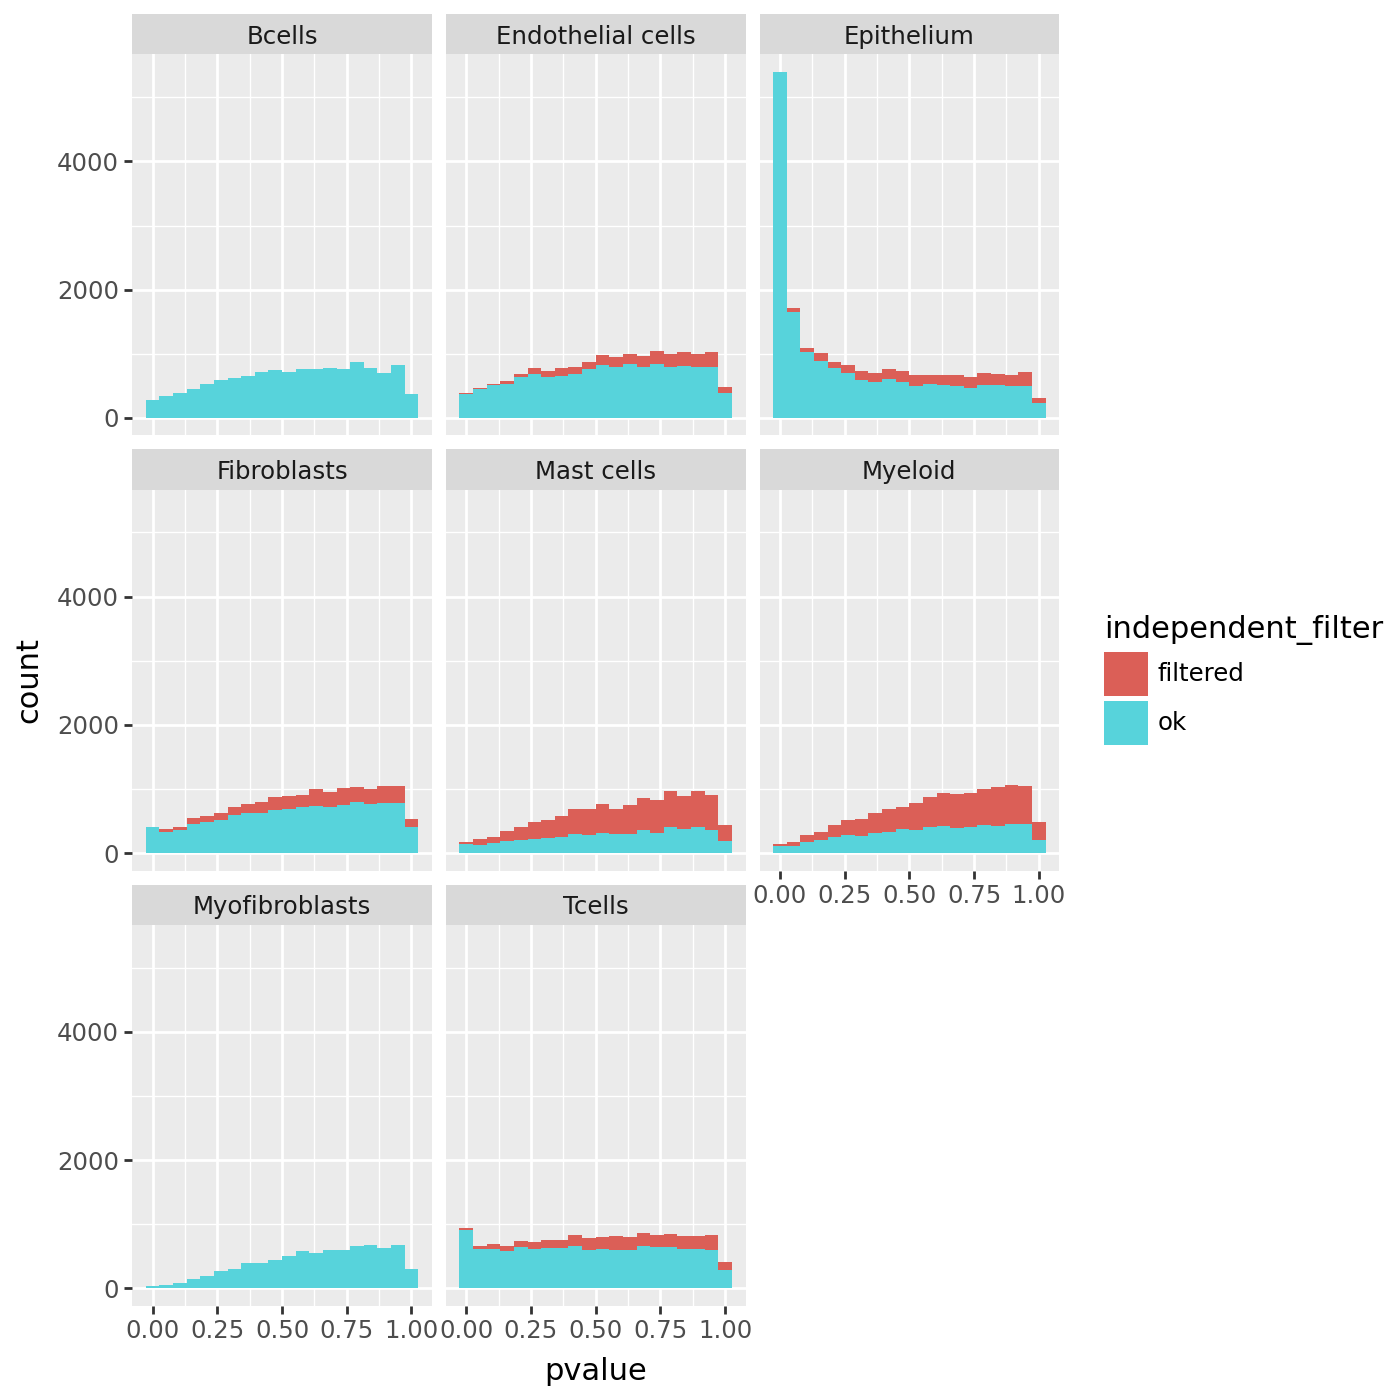

In [58]:
pn.ggplot(df_de_all, pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

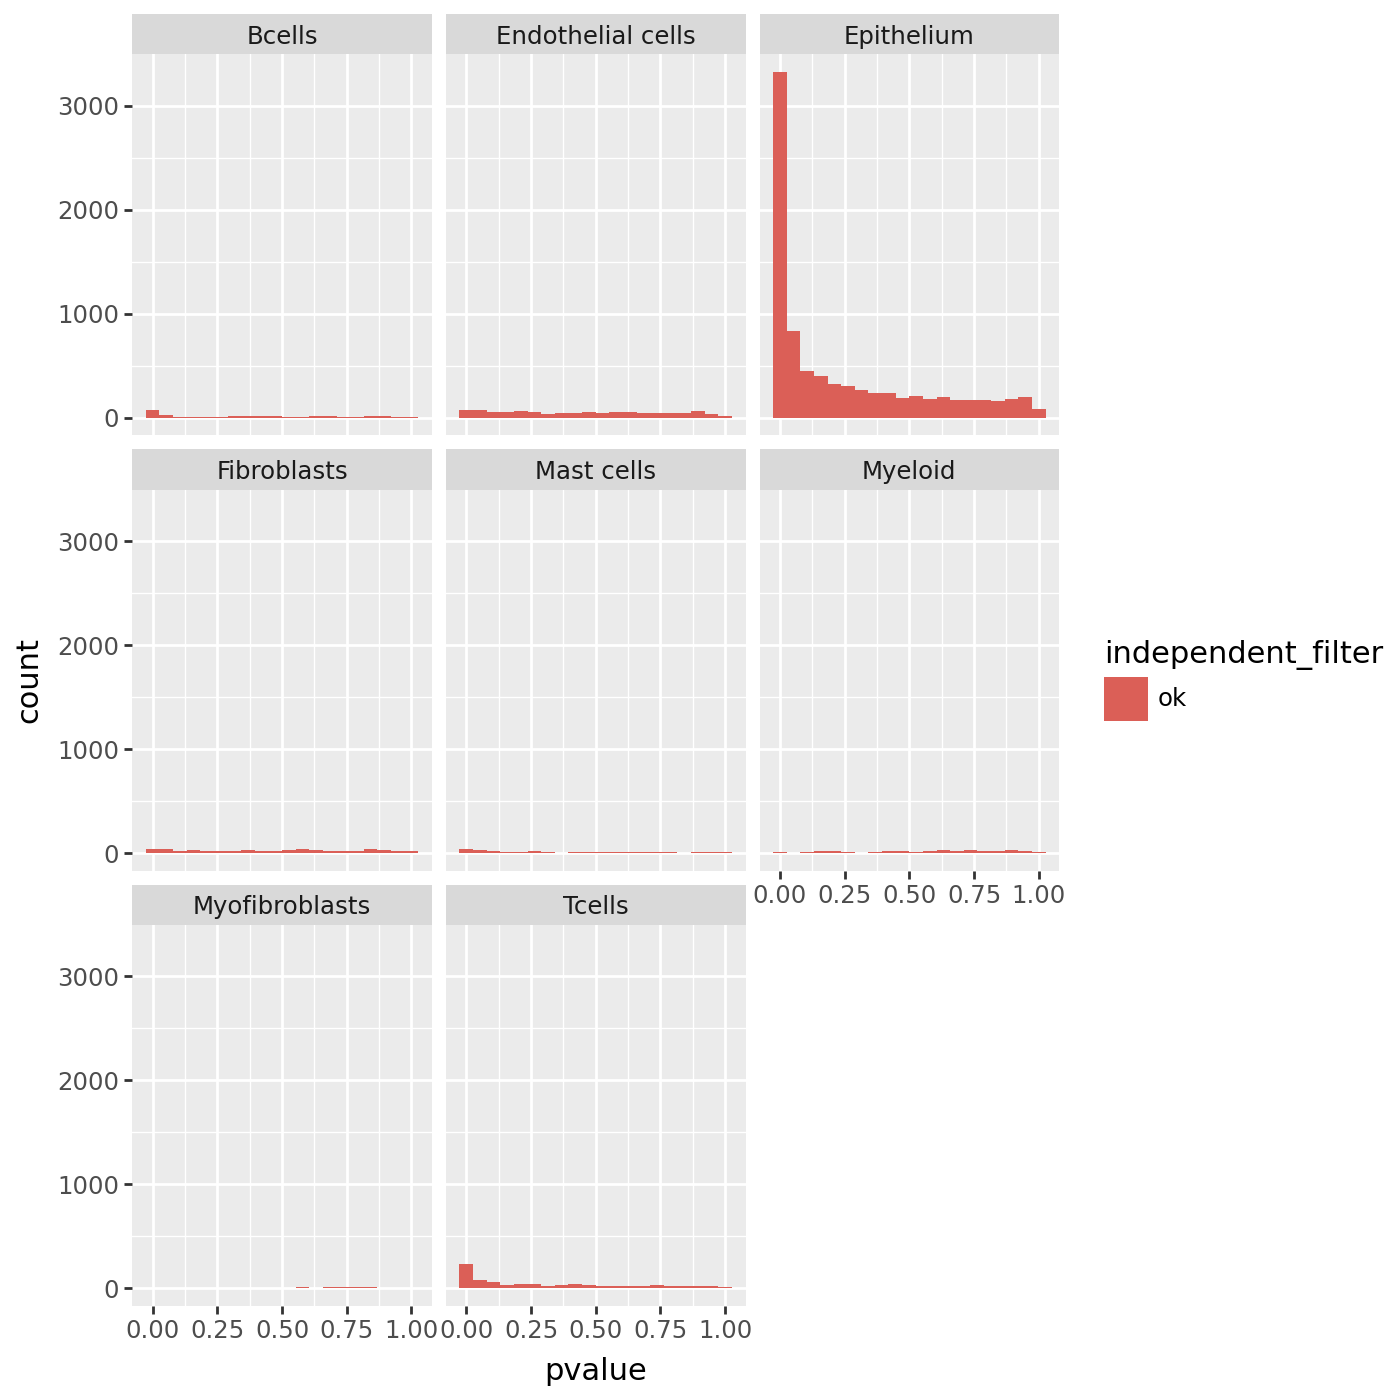

In [59]:
pn.ggplot(df_de_all.query("baseMean>100"), pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

In [60]:
df_de_all.loc['MUC2']

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
MUC2    16.321445       -8.039444  2.013076 -3.993611  6.507466e-05   
MUC2  3046.148879      -11.877395  1.242959 -9.555745  1.226981e-21   
MUC2     5.803028       -6.316275  2.413409 -2.617159  8.866511e-03   
MUC2     8.102735       -8.054100  1.538508 -5.235007  1.649782e-07   
MUC2     1.319802       -3.586846  3.434618 -1.044322  2.963366e-01   
MUC2     8.730831       -8.270196  1.936884 -4.269845  1.956086e-05   
MUC2     5.722880       -6.248969  1.796252 -3.478893  5.034895e-04   
MUC2    13.855176       -3.803179  2.124019 -1.790558  7.336418e-02   

              padj  log2FoldChange_shrunk  lfcSE_shrunk           celltype  \
MUC2  5.313860e-03          -8.740501e+00      2.810831             Tcells   
MUC2  9.600033e-20          -1.204418e+01      1.361139         Epithelium   
MUC2  5.126064e-01          -8.665065e-03      0.077734         Mast cells   
MUC2  5.770937e-05          -1.035954e+01      3.027029        Fibroblasts   
MUC2  9.999551e-01          -3.935995e-07      0.003916     Myofibroblasts   
MUC2  4.920282e-03          -9.158210e+00      2.877004  Endothelial cells   
MUC2  9.018057e-02          -3.084757e-06      0.004568            Myeloid   
MUC2  9.995259e-01          -7.646674e-07      0.001679             Bcells   

     independent_filter  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok  
MUC2                 ok

#### shrunk

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 58 rows containing missing values.


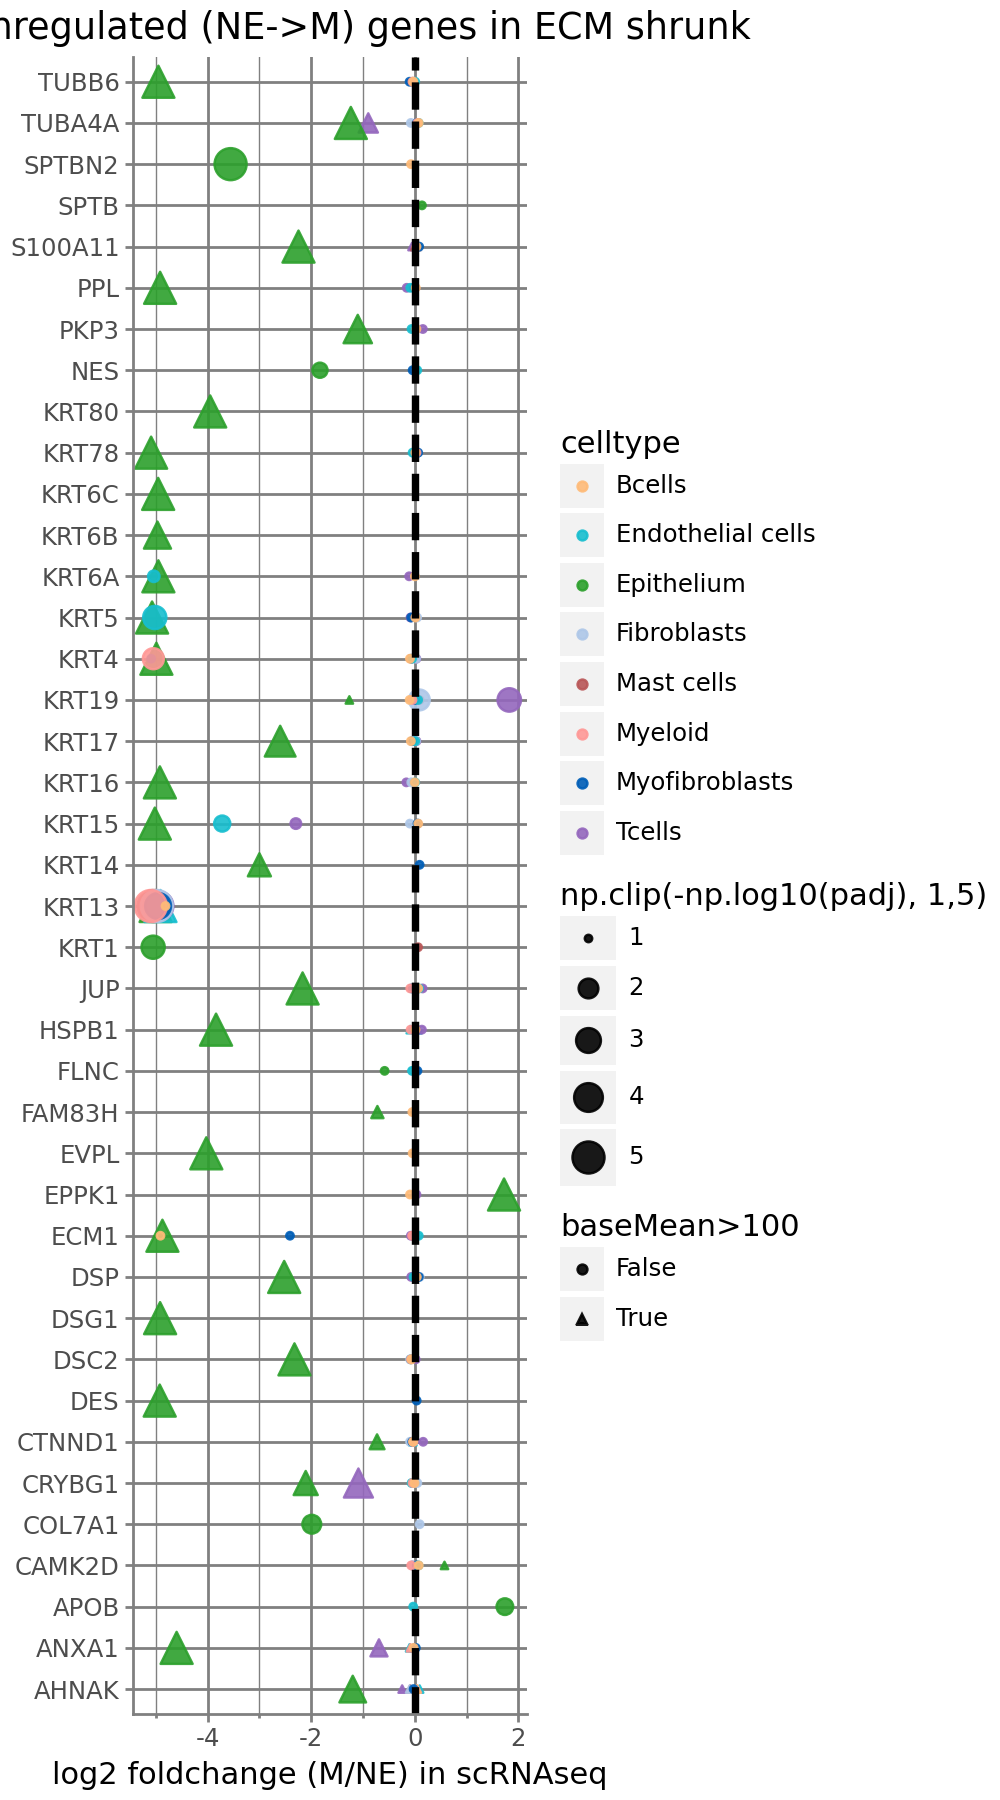

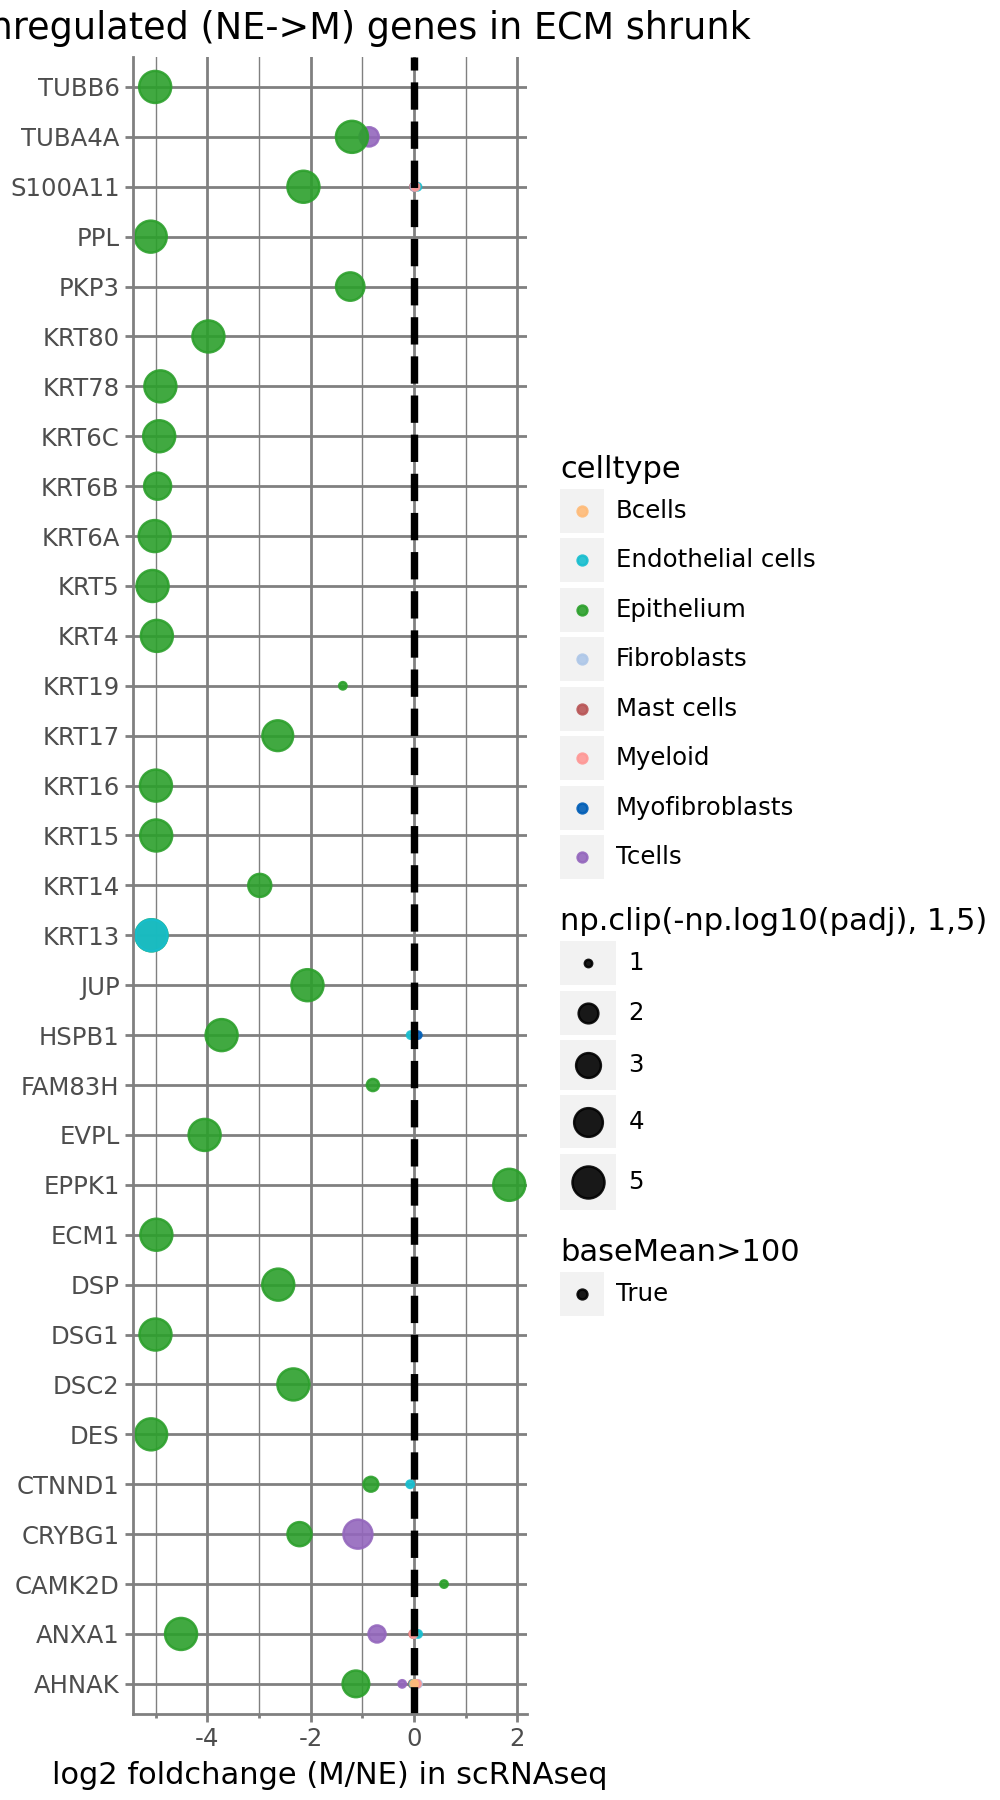

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_patient_diag.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 58 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_patient_diag_baseLine_filtered.svg


In [61]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p.show(), p2.show()
p.save (f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag_baseLine_filtered.svg')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_patient_diag.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_patient_diag_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


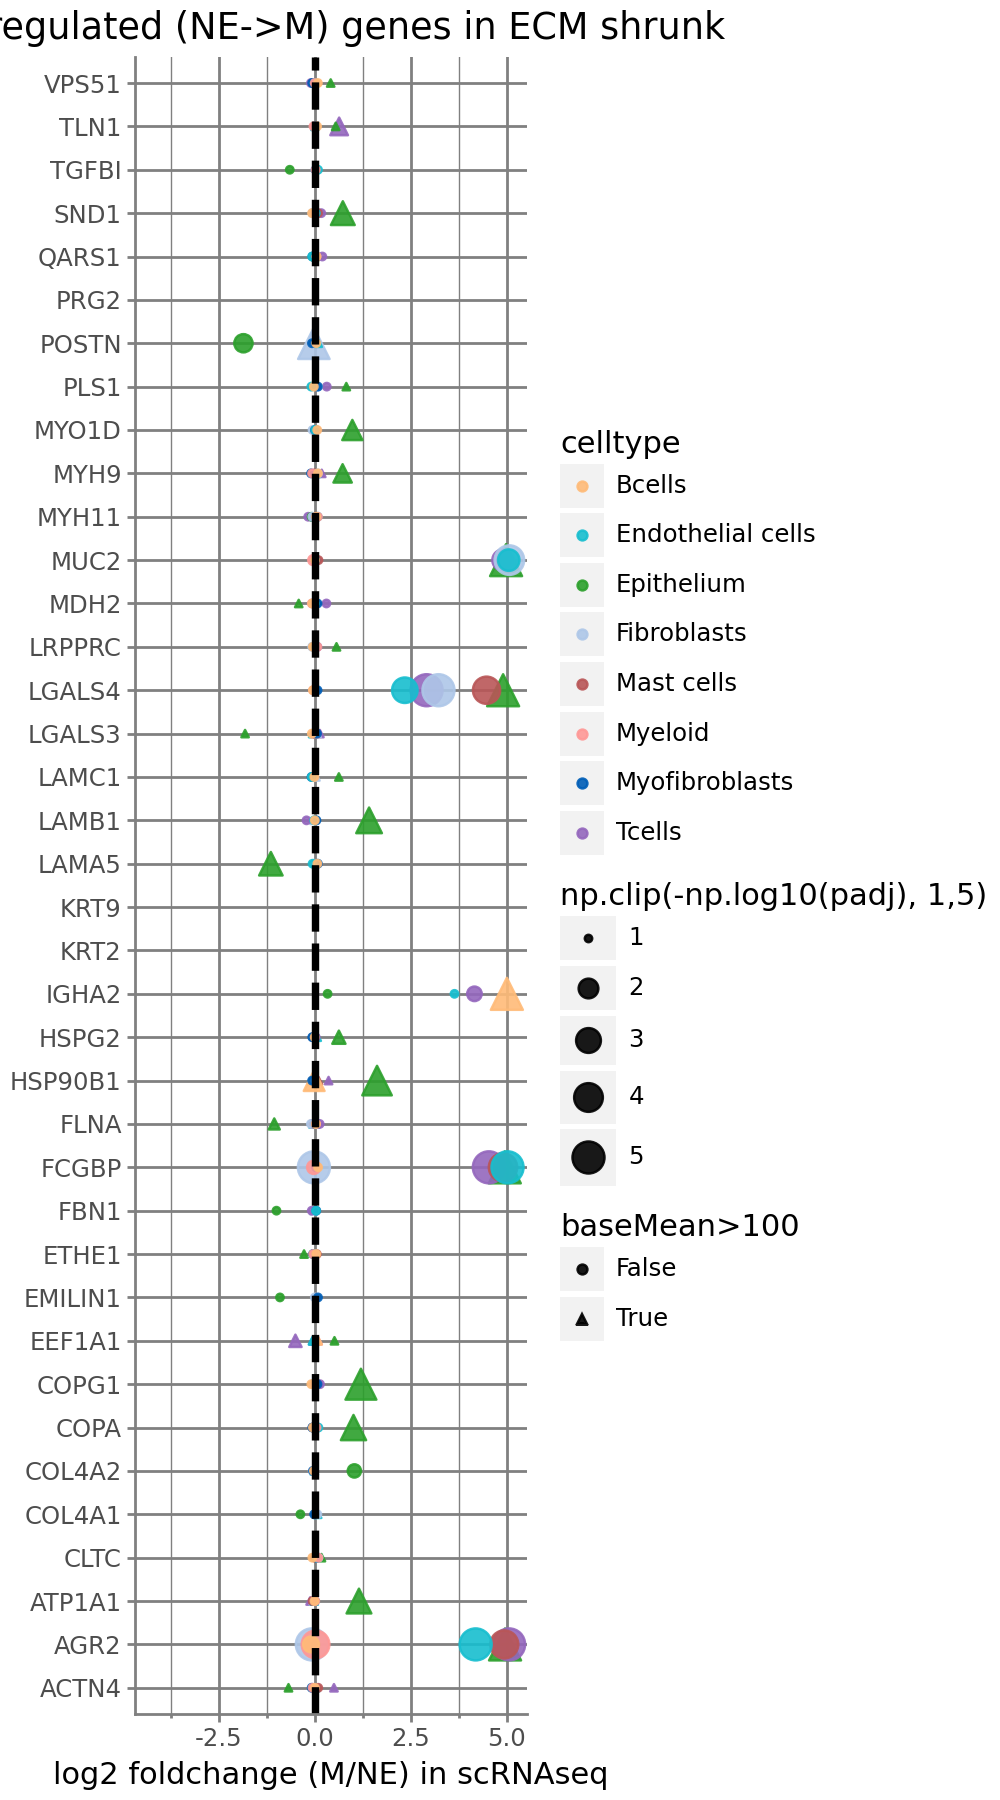

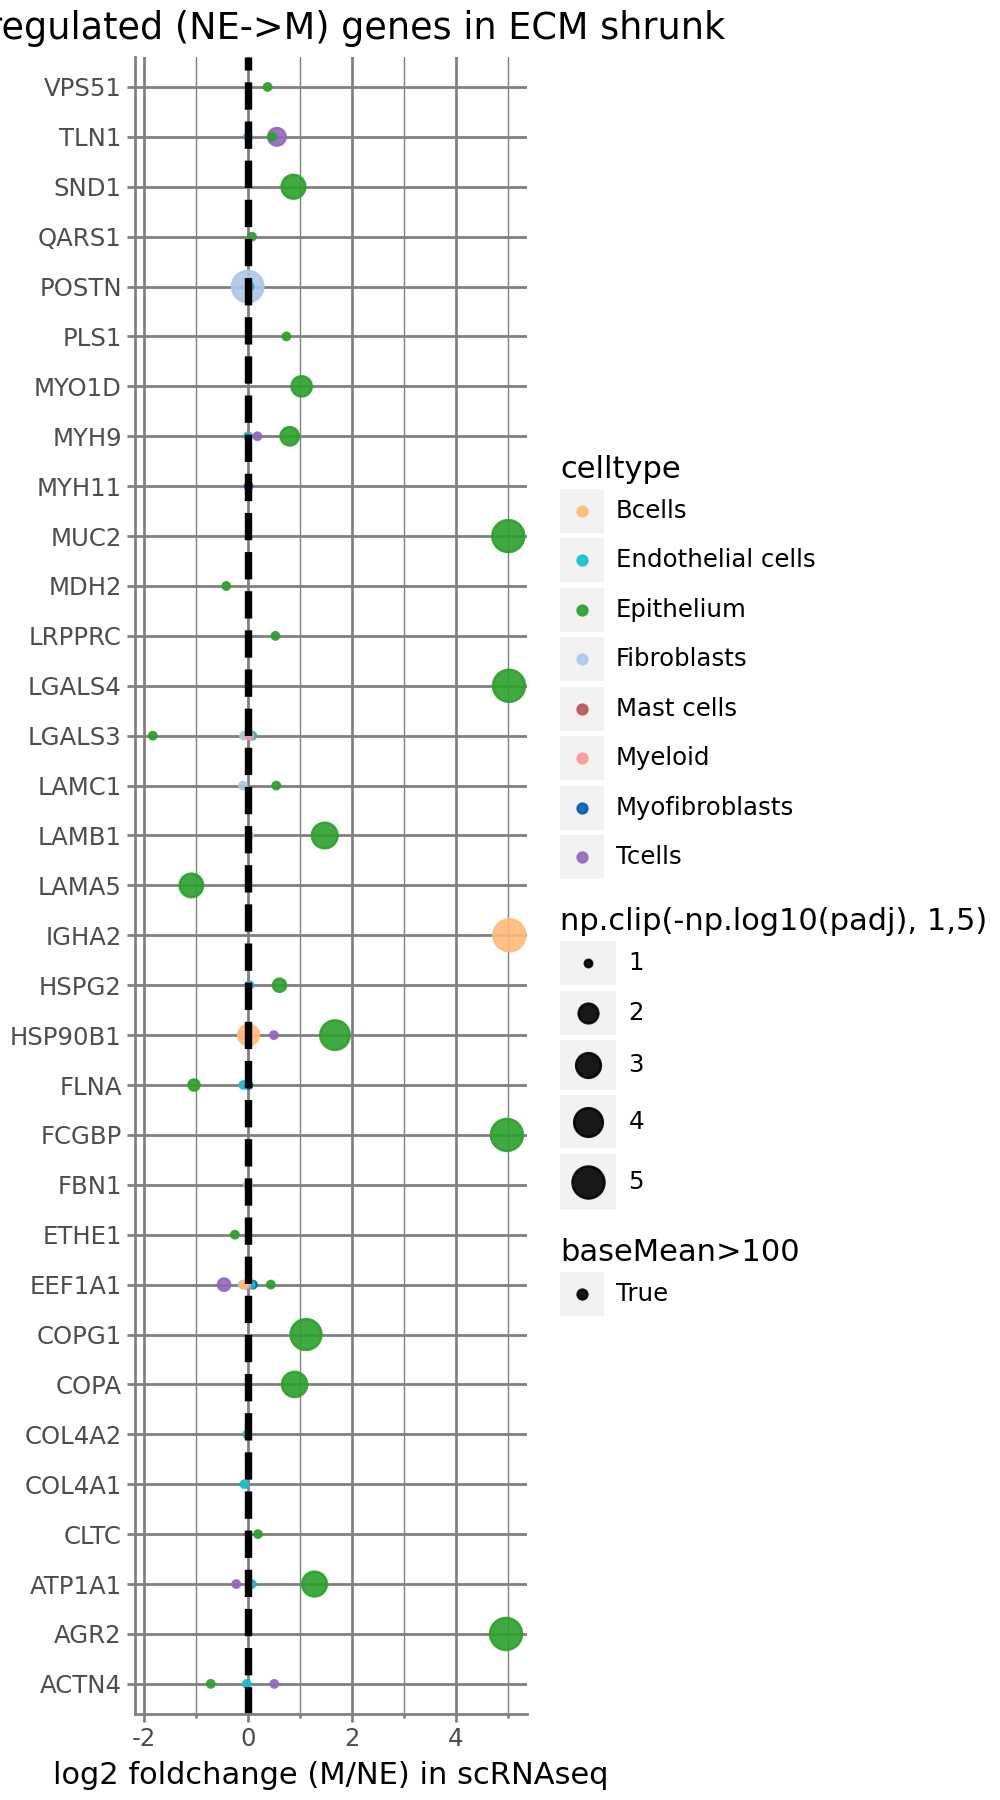

(None, None)

In [62]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_baseMean.svg')

p.show(), p2.show()

#### unshrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 58 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 58 rows containing missing values.


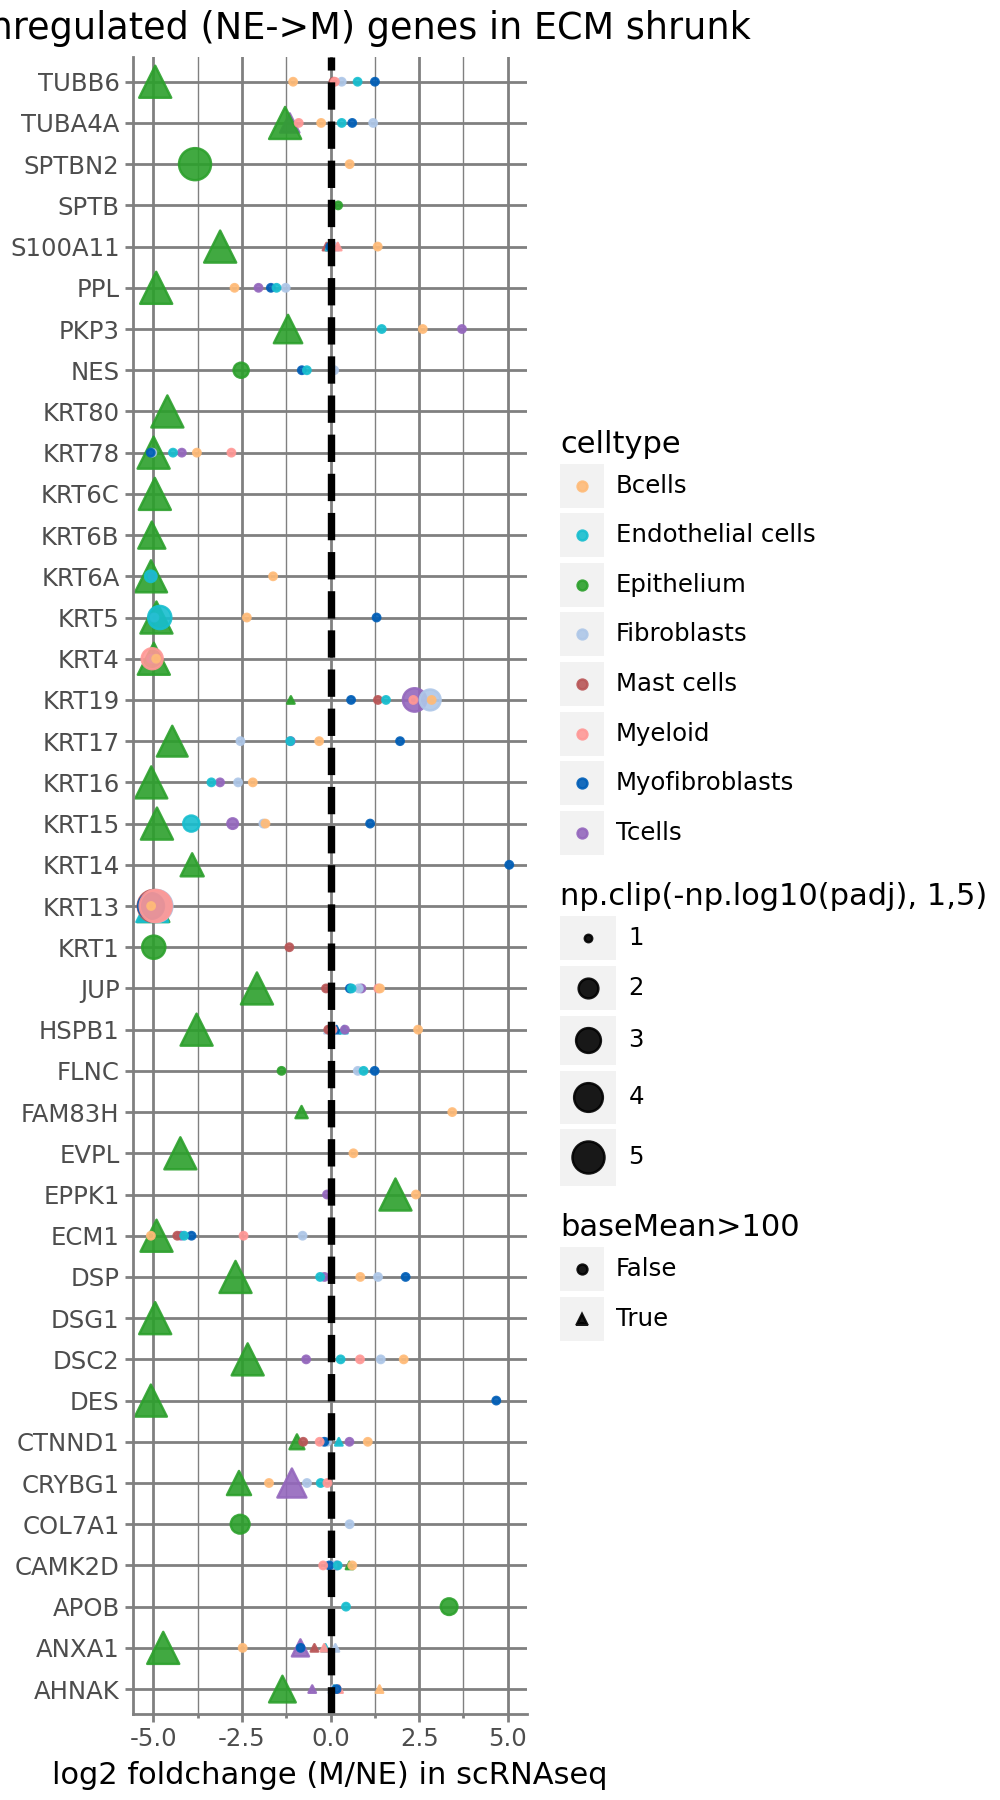

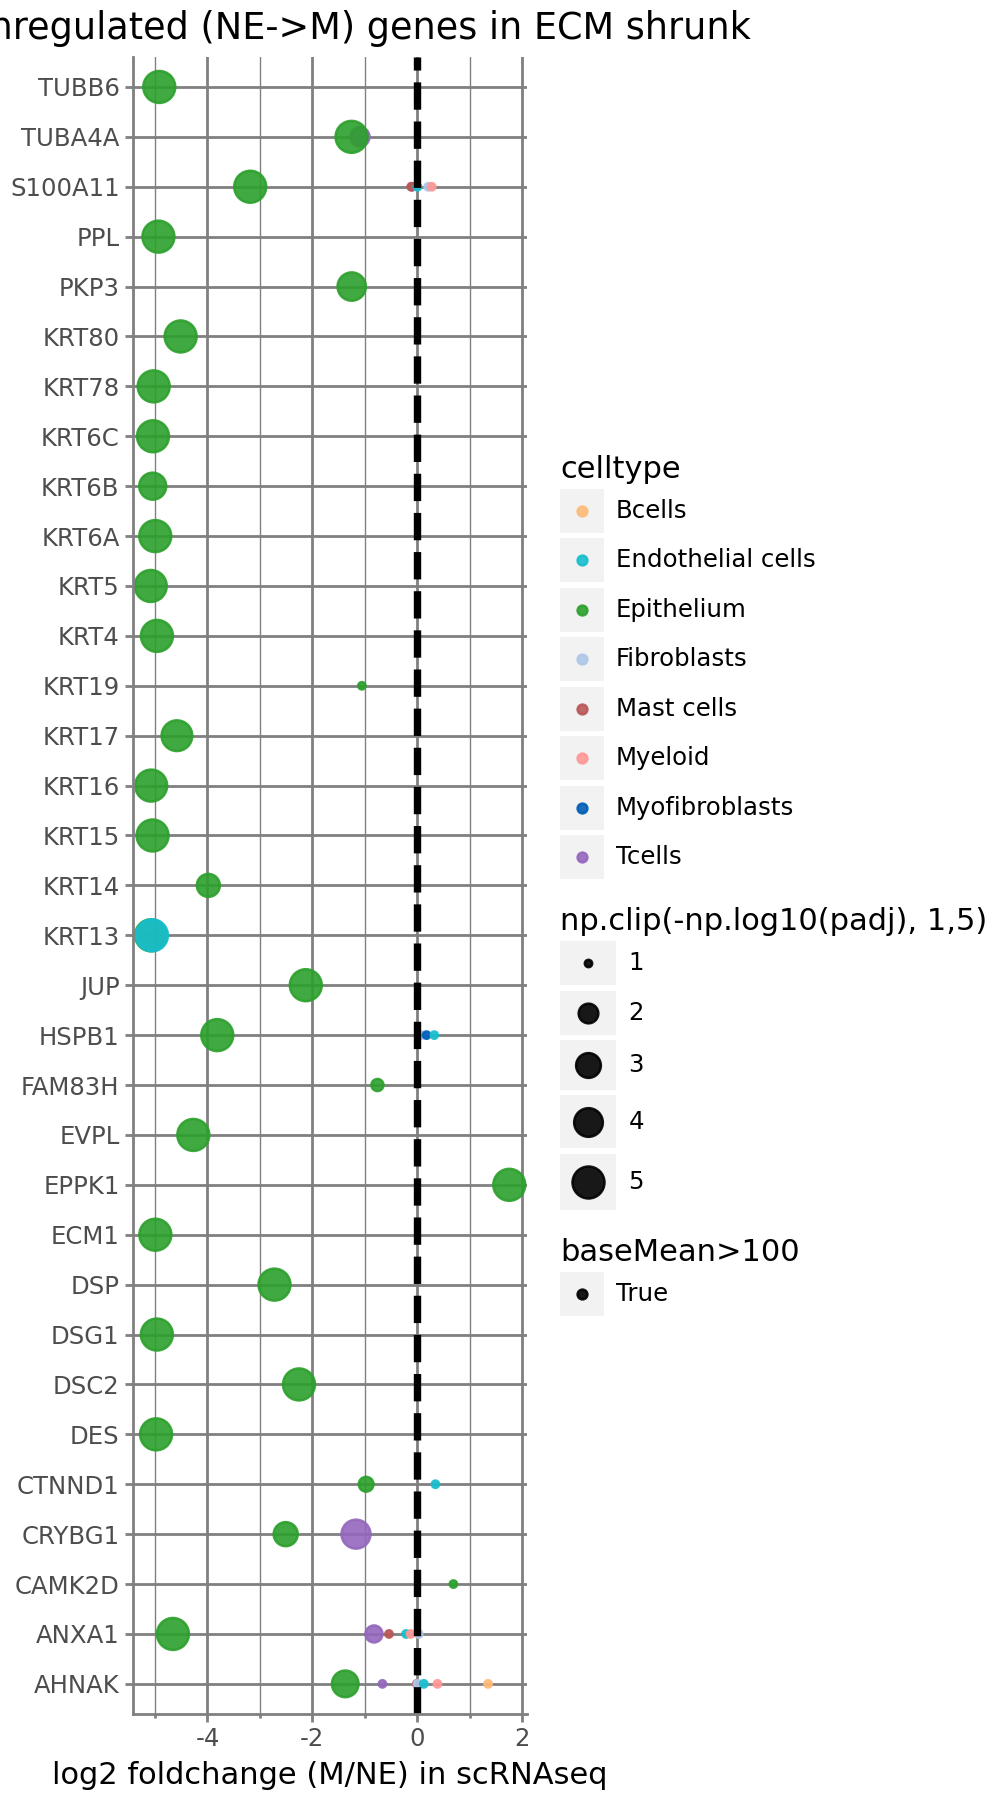

(None, None)

In [63]:
p = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg')

p.show(), p2.show()

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


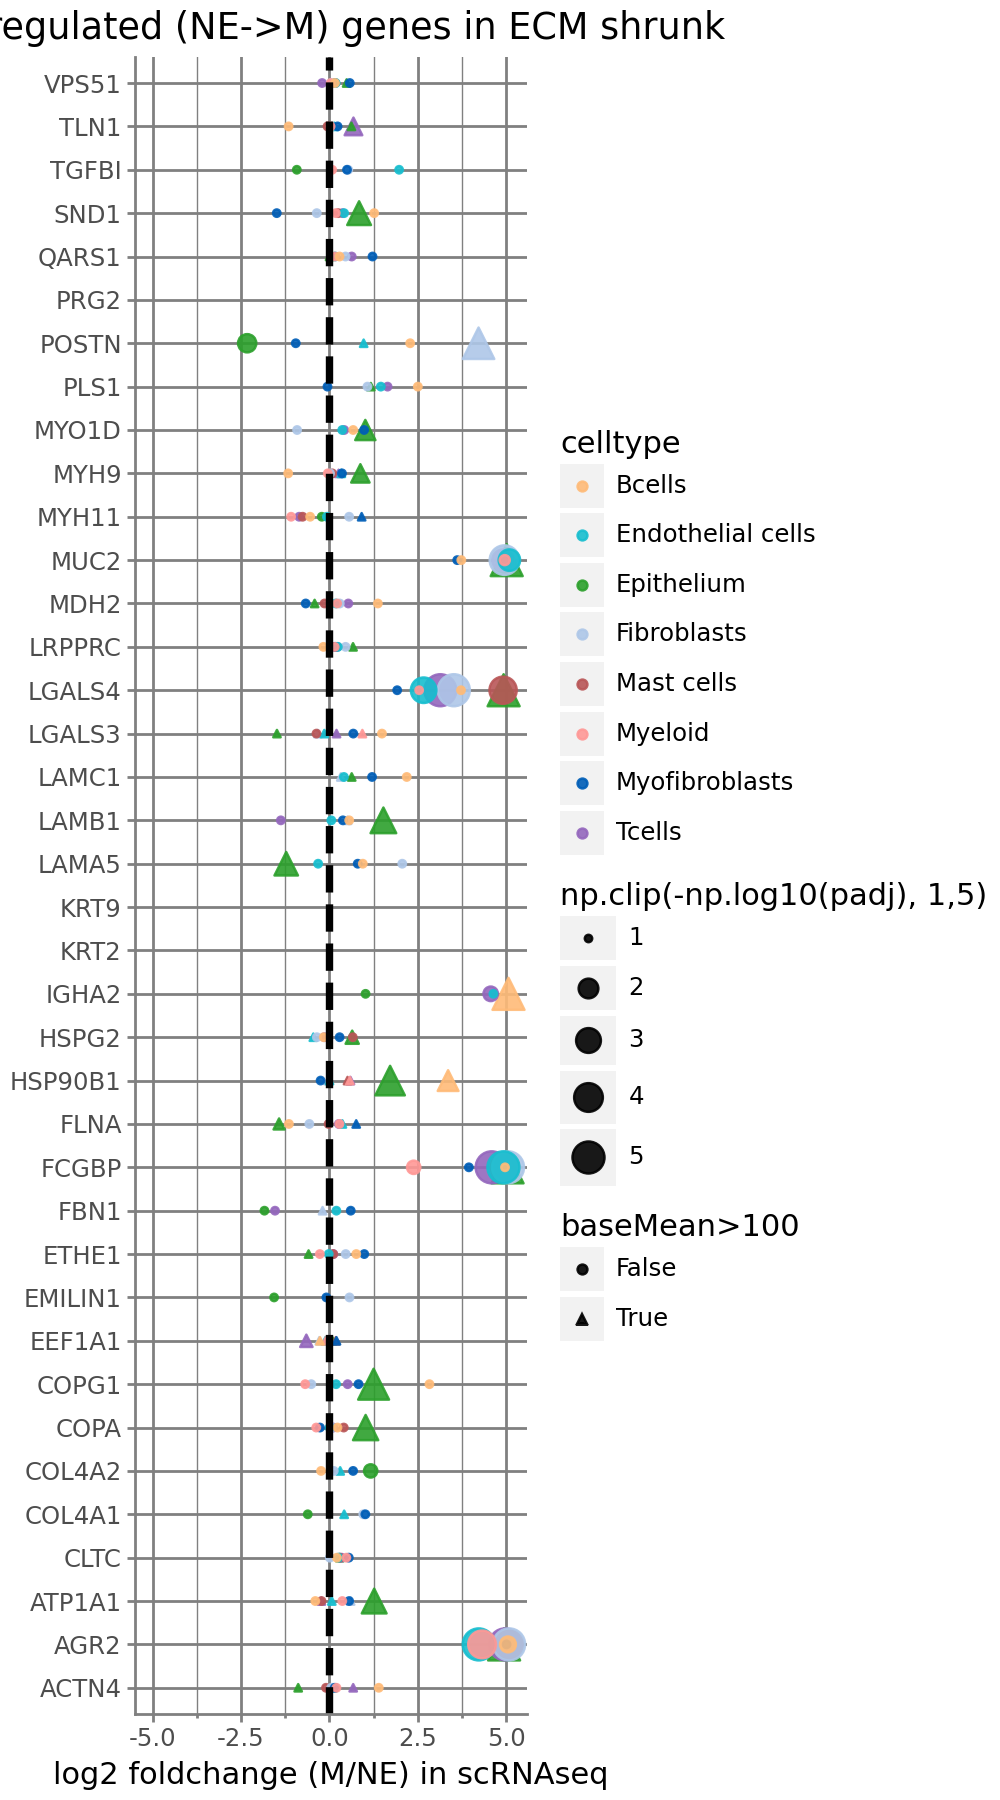

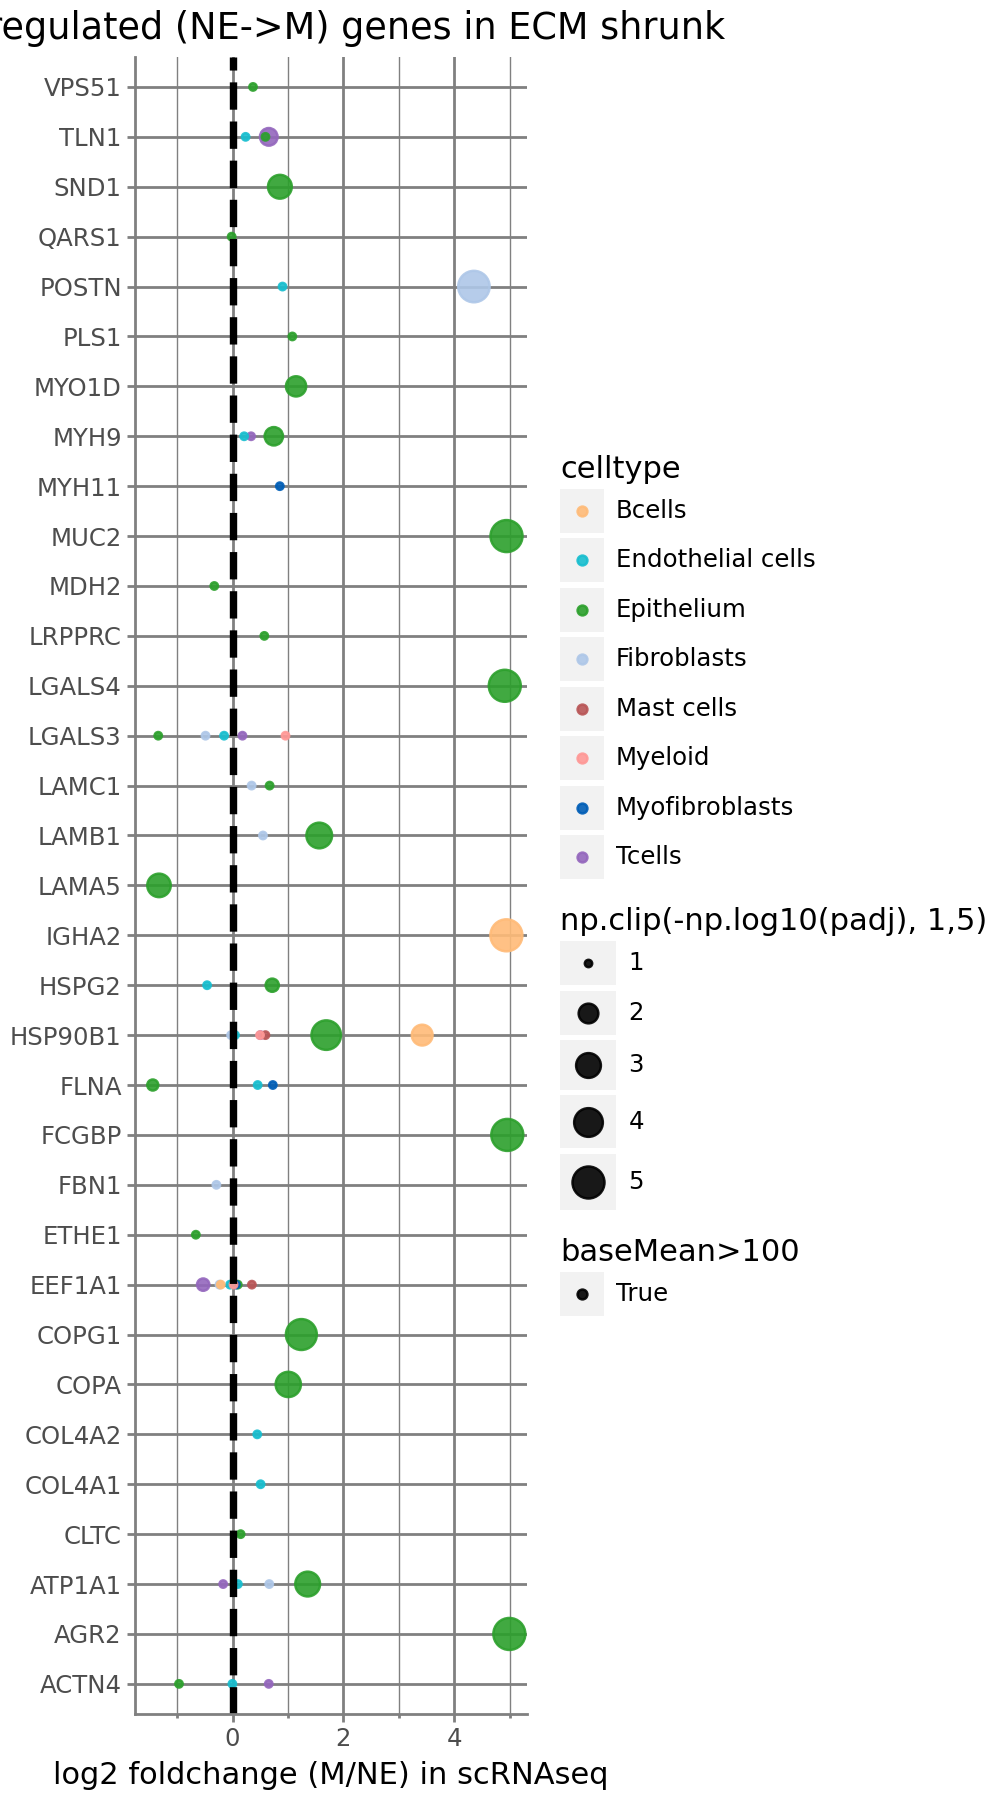

(None, None)

In [64]:
p = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg')

p.show(), p2.show()

### ~diagnosis

In [65]:
contrast = ["diagnosis",  "NE", "M"]
design_factors = ['diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.55 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 2.96 seconds.

Fitting LFCs...
... done in 2.00 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 65 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.48 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.90 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 3.79 seconds.

Fitting LFCs...
... done in 3.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 358 outlier genes.

Fitting dispersions...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.17 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-x

Fit type used for VST : parametric


Fitting dispersions...
... done in 2.99 seconds.

/opt/conda/lib/python3.11/site-packages/anndata/_core/views.py:144: RuntimeWarning: divide by zero encountered in divide


Celltype: Mast cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.30 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 2.10 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 36 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xb

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.62 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.07 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 2.32 seconds.

Fitting LFCs...
... done in 1.89 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 61 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xb

Fit type used for VST : parametric


Fitting dispersions...
... done in 2.08 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.02 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 1.08 seconds.

Fitting LFCs...
... done in 0.75 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Fit type used for VST : parametric


Fitting dispersions...
... done in 1.11 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.99 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 2.29 seconds.

Fitting LFCs...
... done in 1.87 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.94 seconds.



Celltype: Myeloid


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.71 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 1.96 seconds.

Fitting LFCs...
... done in 1.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 79 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xb

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.81 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.57 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 1.78 seconds.

Fitting LFCs...
... done in 1.64 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.71 seconds.



Celltype: Other


/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 504 rows containing non-finite values.


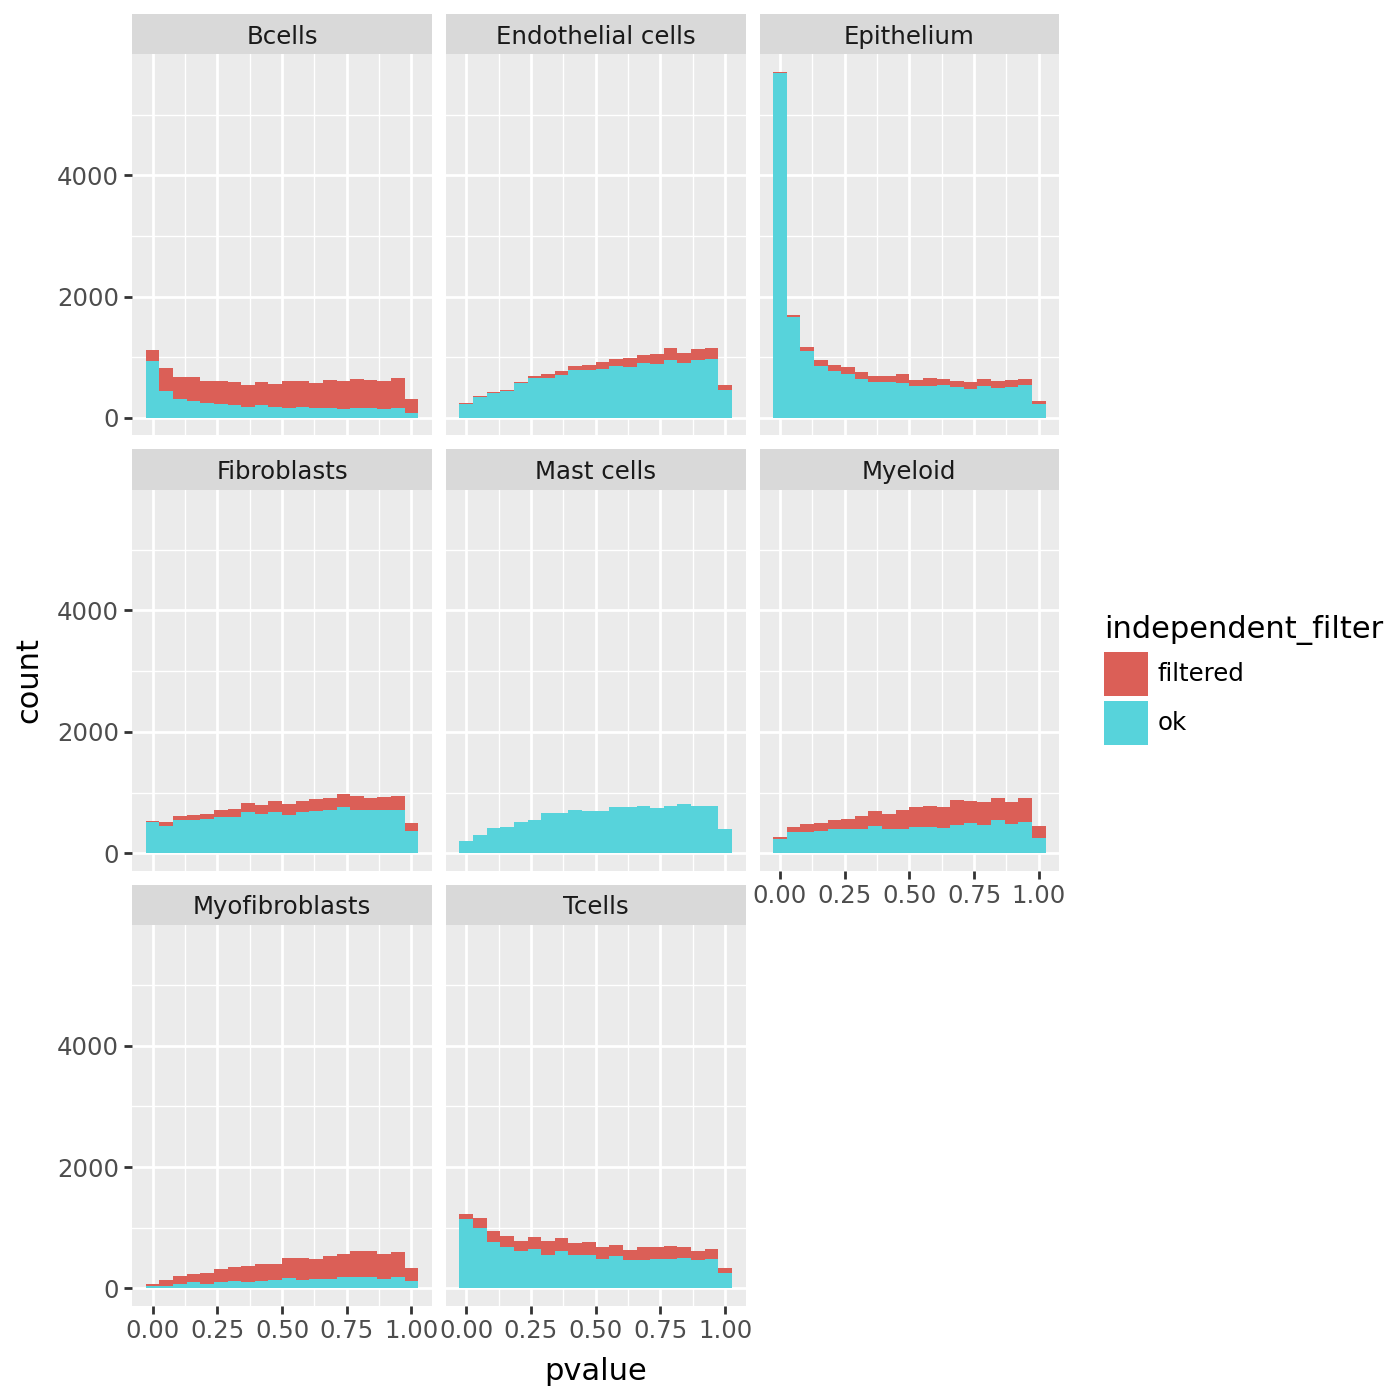

In [67]:
pn.ggplot(df_de_all, pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 115 rows containing non-finite values.


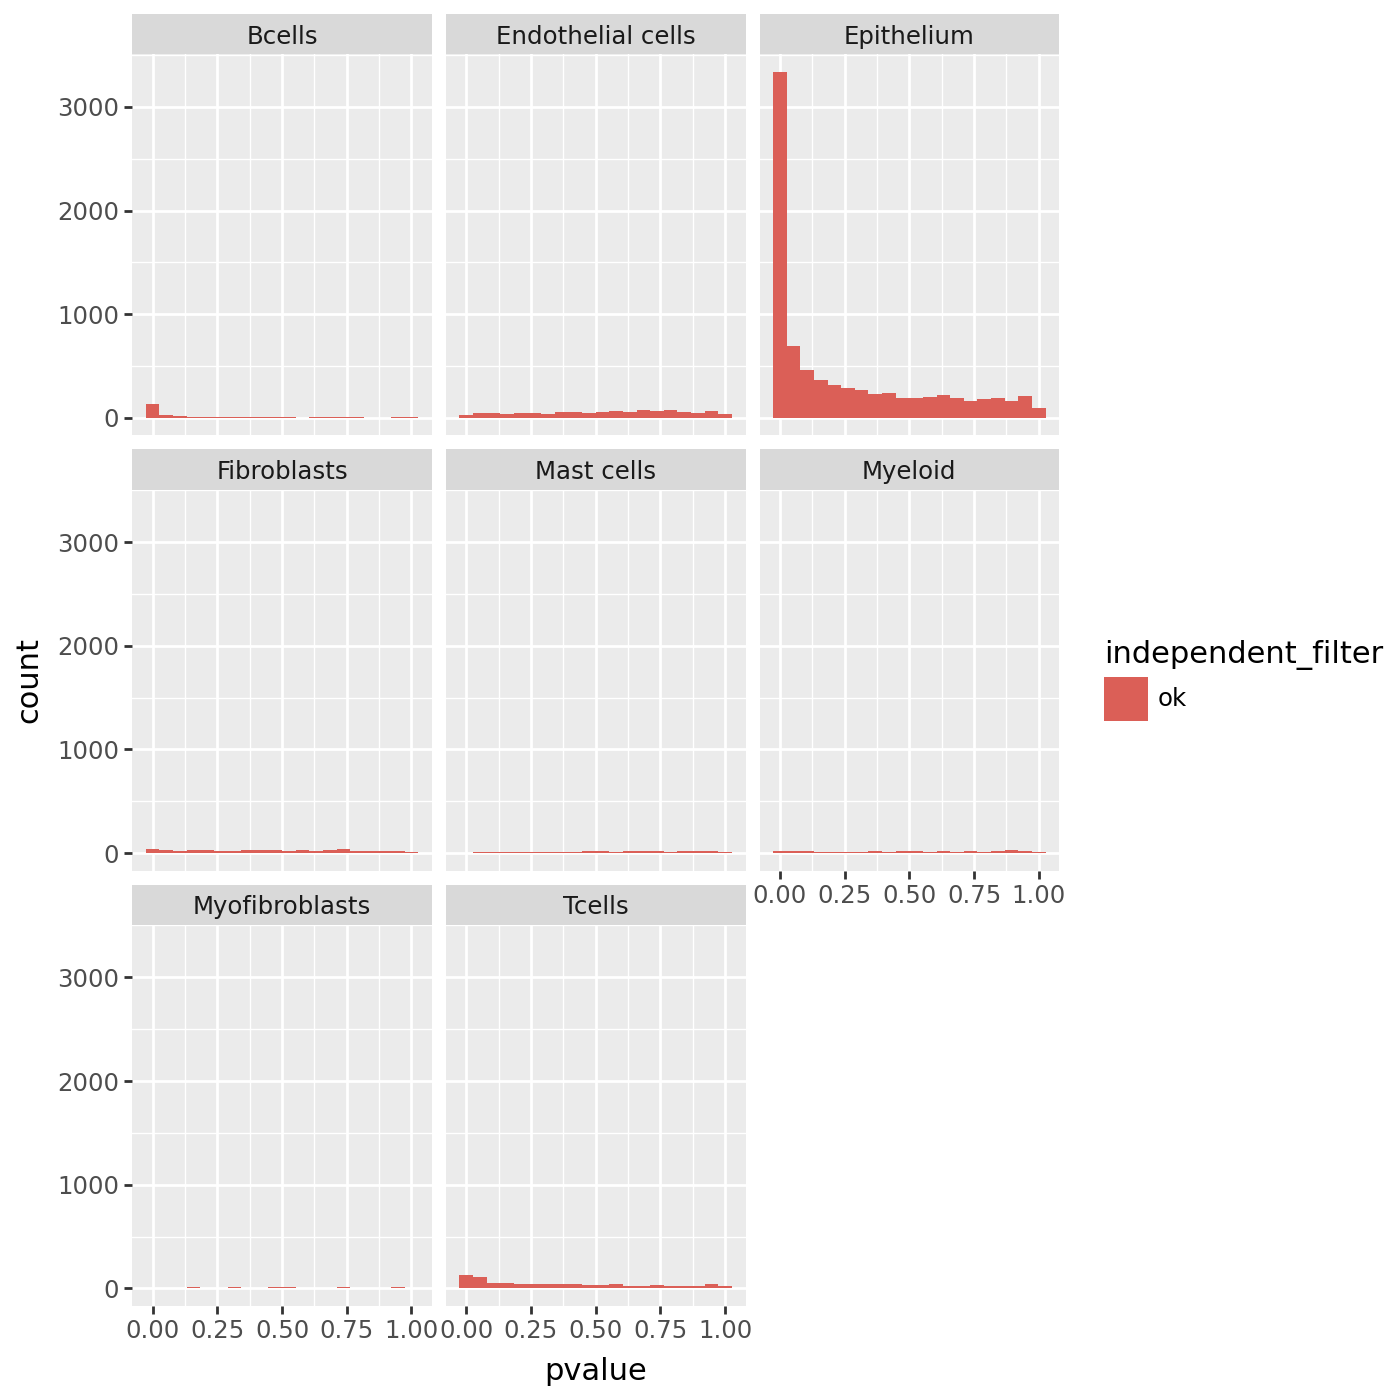

In [68]:
pn.ggplot(df_de_all.query("baseMean>100"), pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

#### shrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_diag.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 84 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_diag_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 84 rows containing missing values.


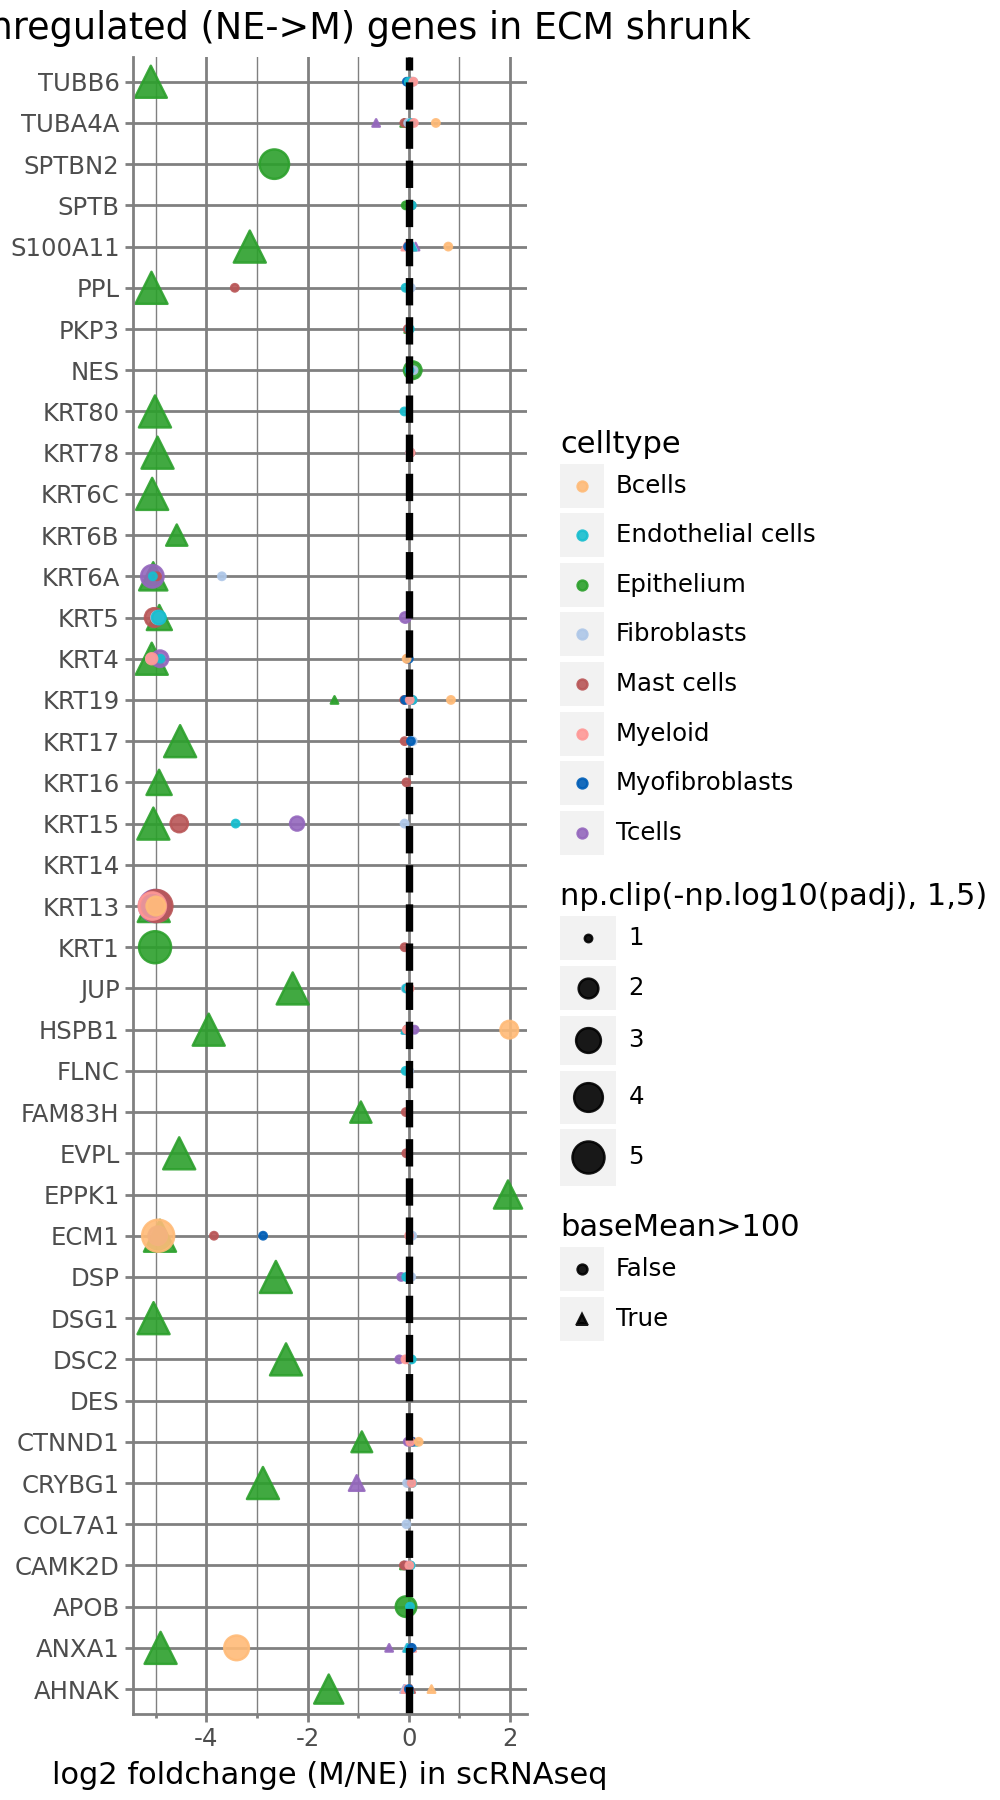

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.


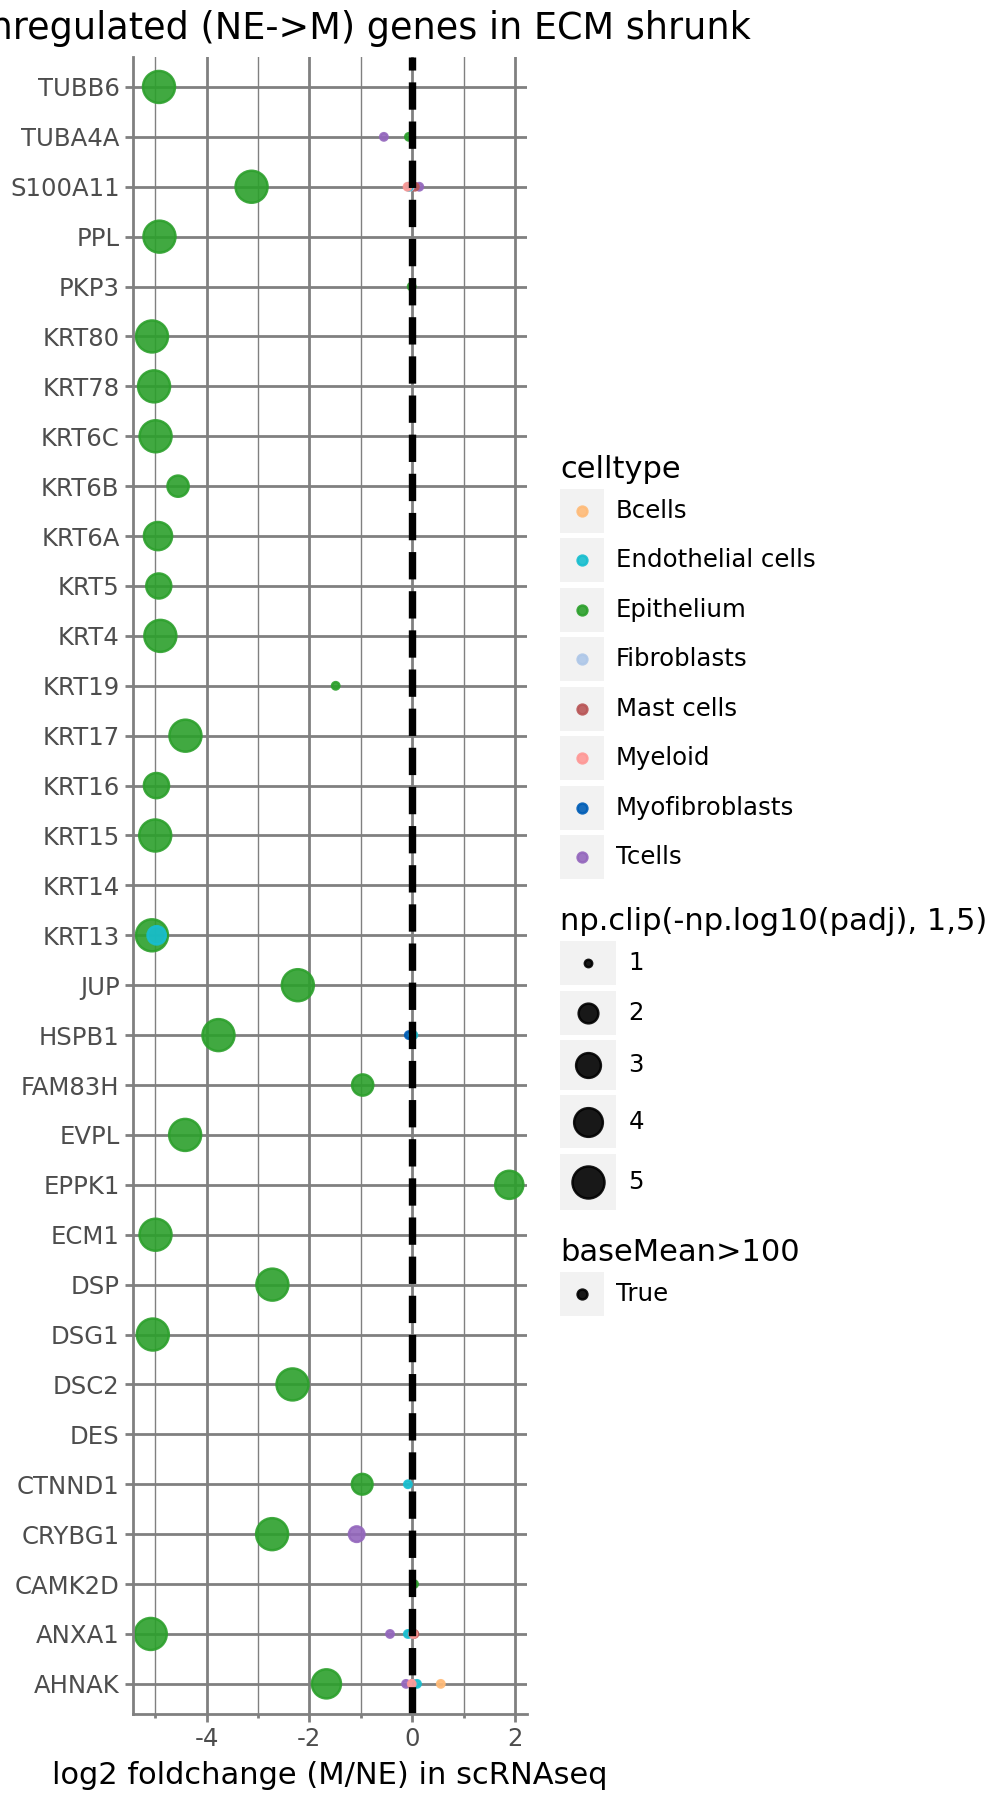

(None, None)

In [69]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_diag.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_diag_baseMean.svg')

p.show(), p2.show()

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_diag.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 36 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_diag_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 36 rows containing missing values.


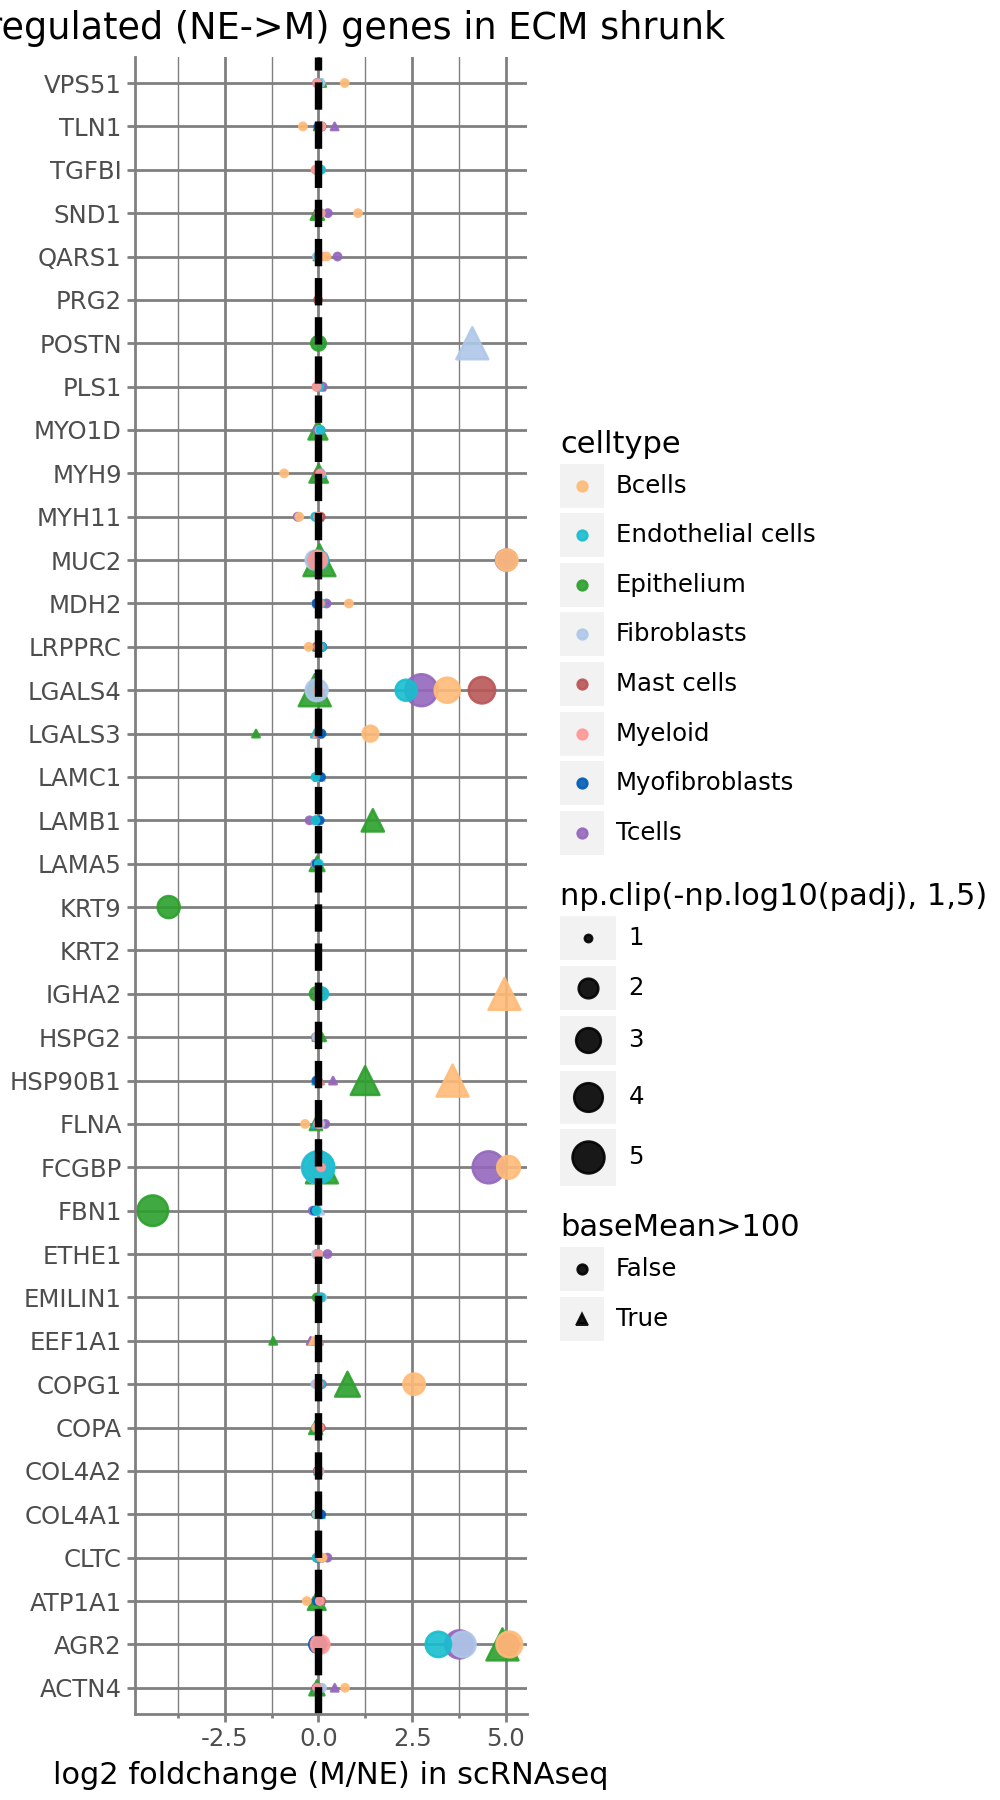

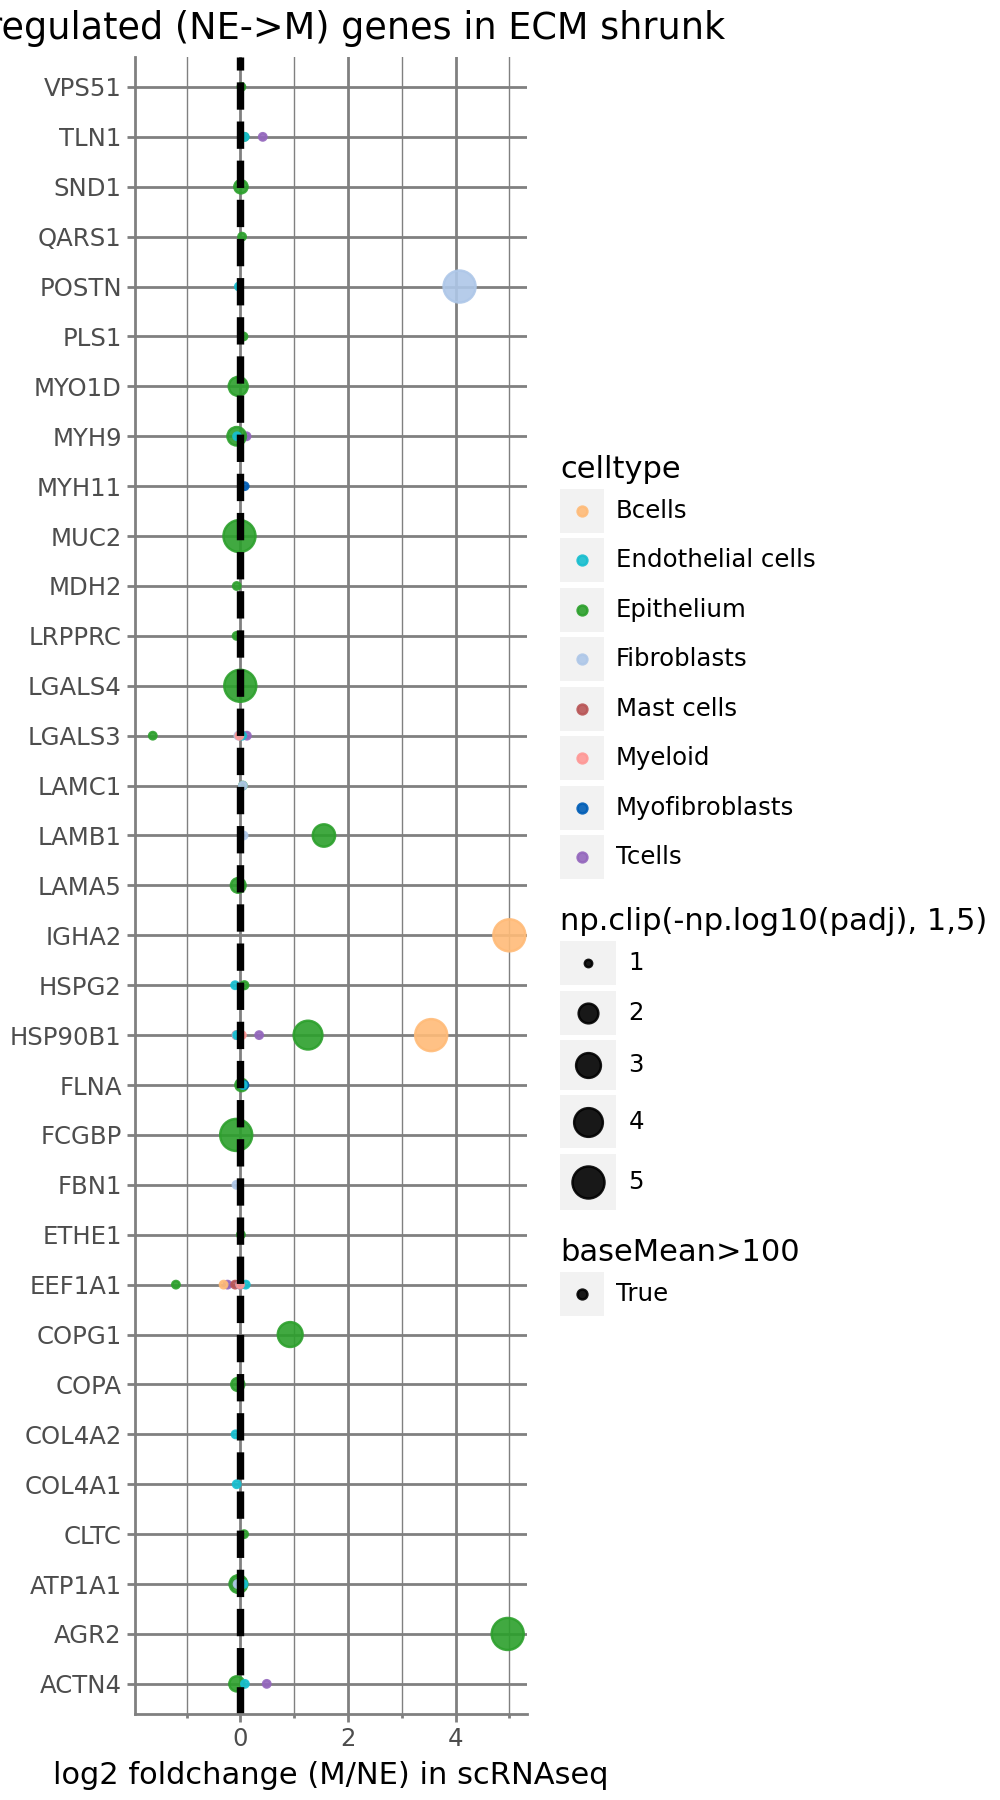

(None, None)

In [70]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_diag.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_diag_baseMean.svg')

p.show(), p2.show()

#### unshrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_diag_unshrunk.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 84 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_diag_unshrunk_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 84 rows containing missing values.


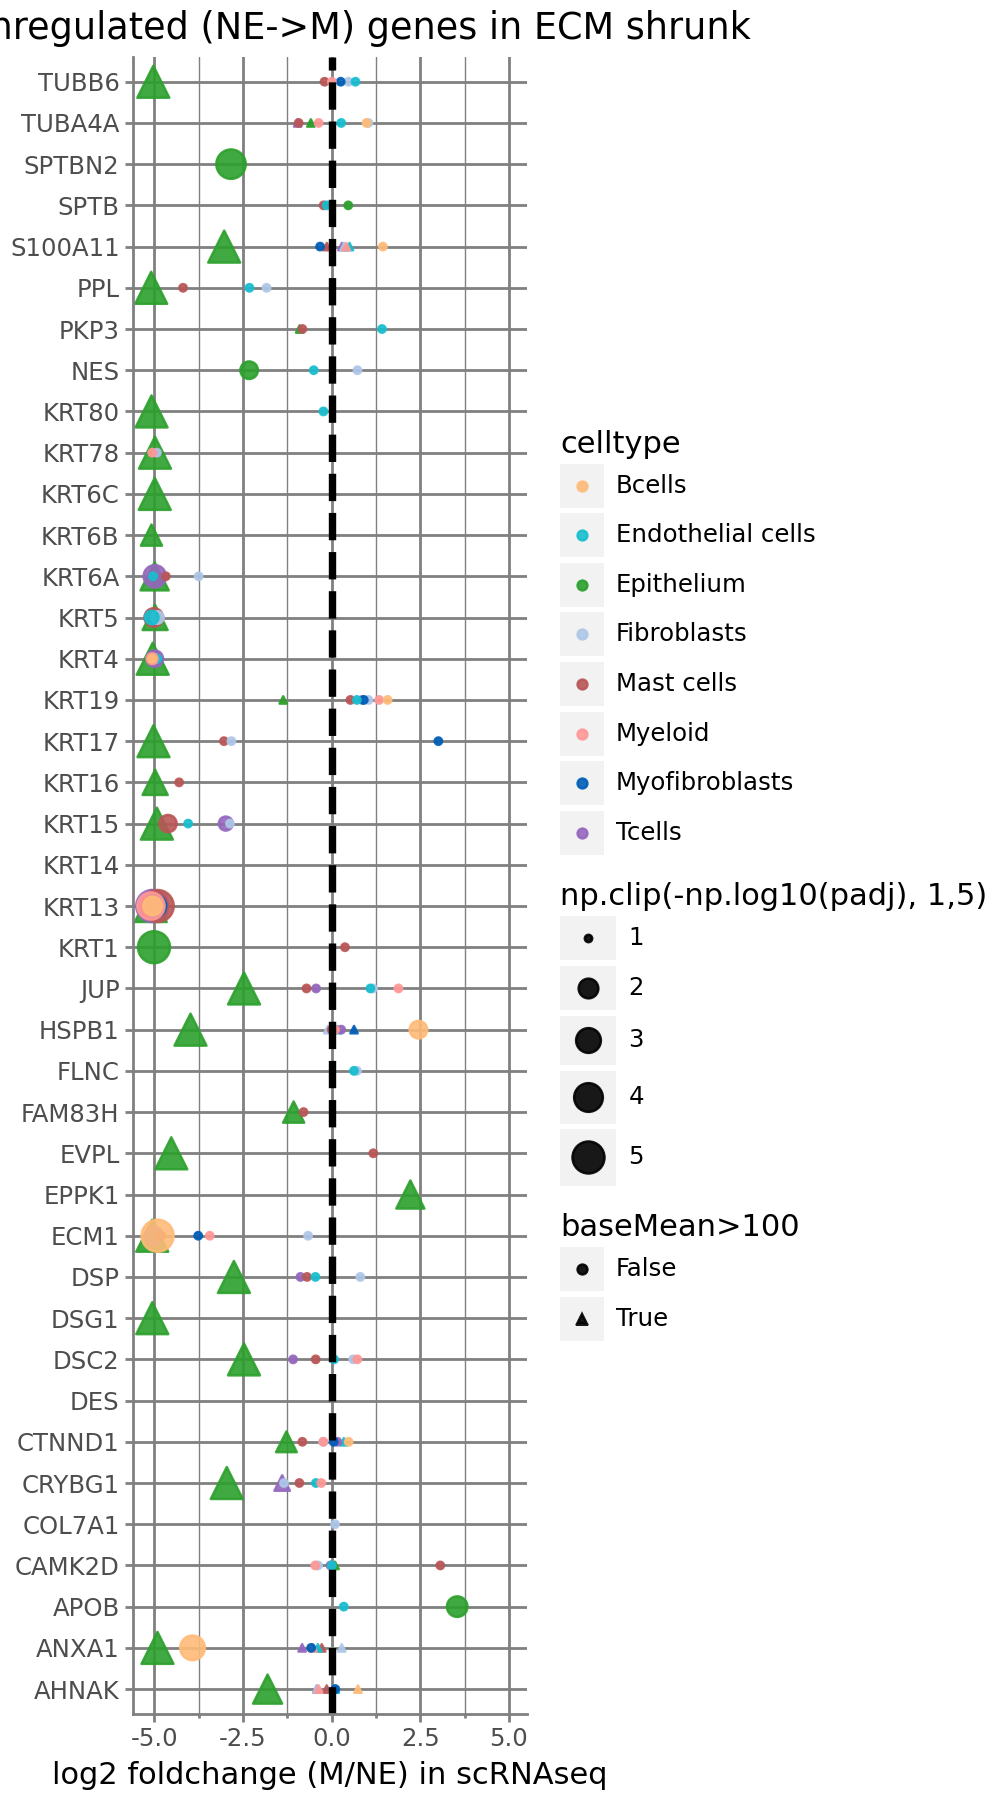

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.


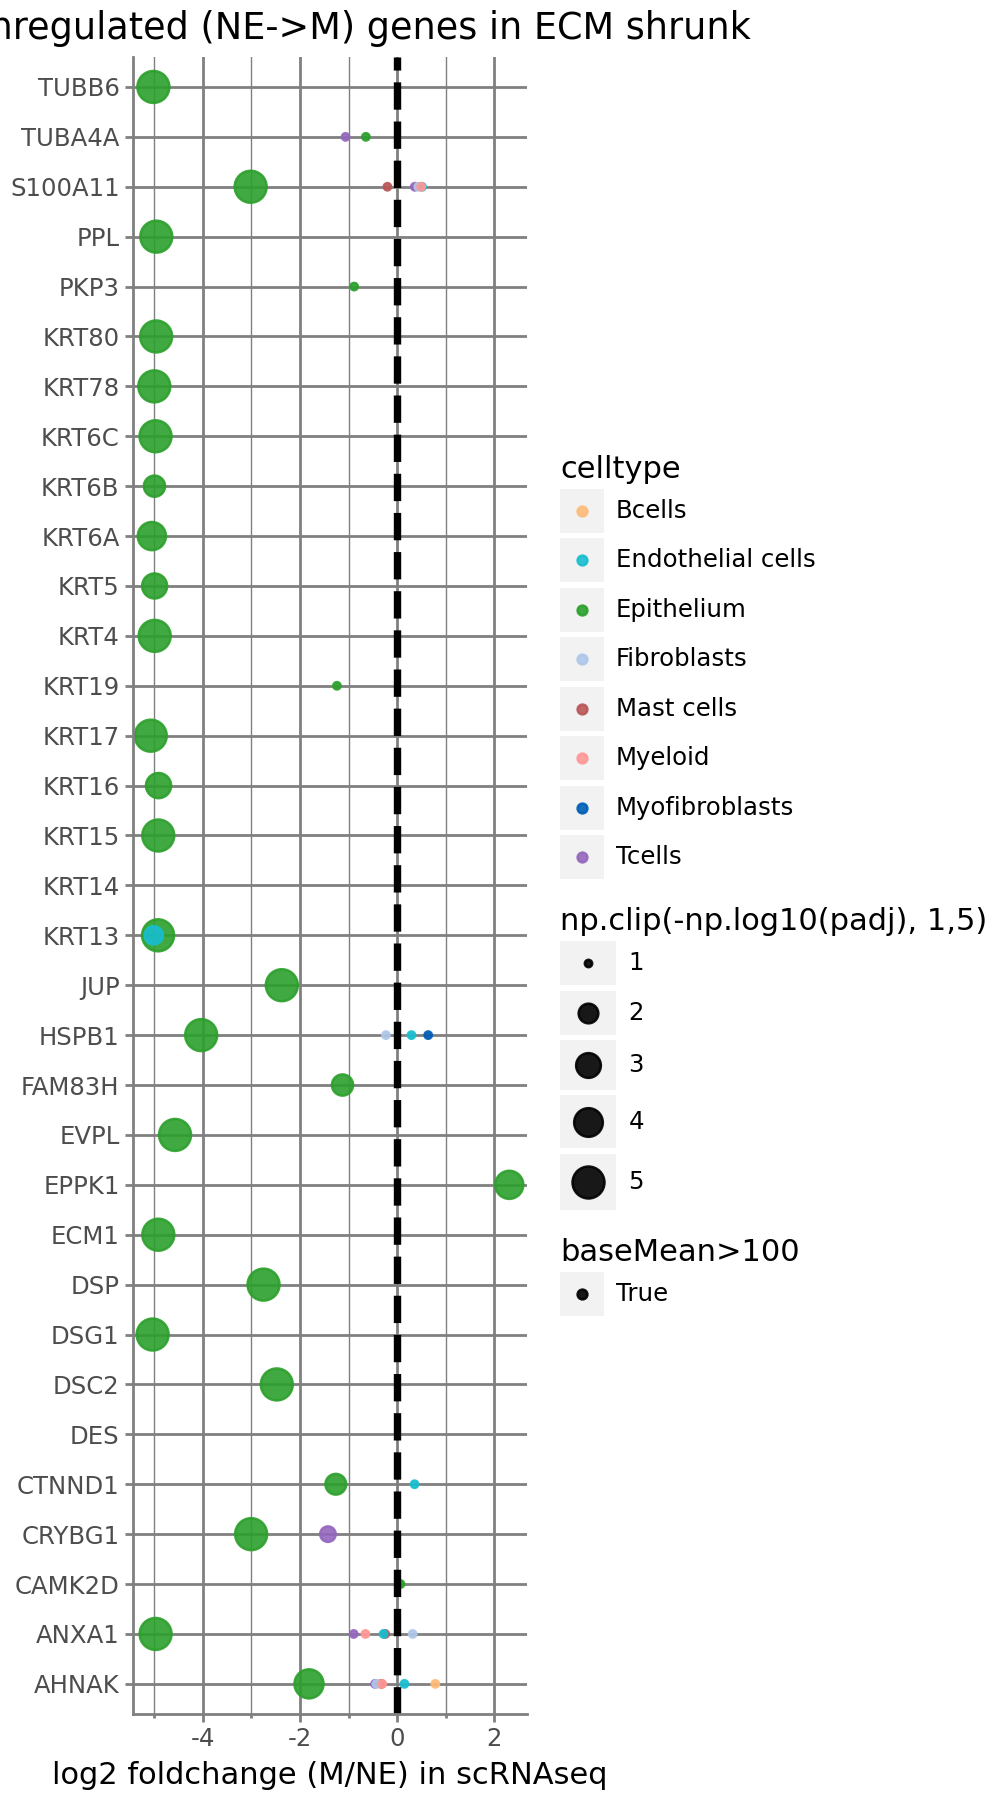

(None, None)

In [71]:
p = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')


p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_diag_unshrunk.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_diag_unshrunk_baseMean.svg')

p.show(), p2.show()

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_diag_unshrunk.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 36 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_diag_unshrunk_baseMean.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 36 rows containing missing values.


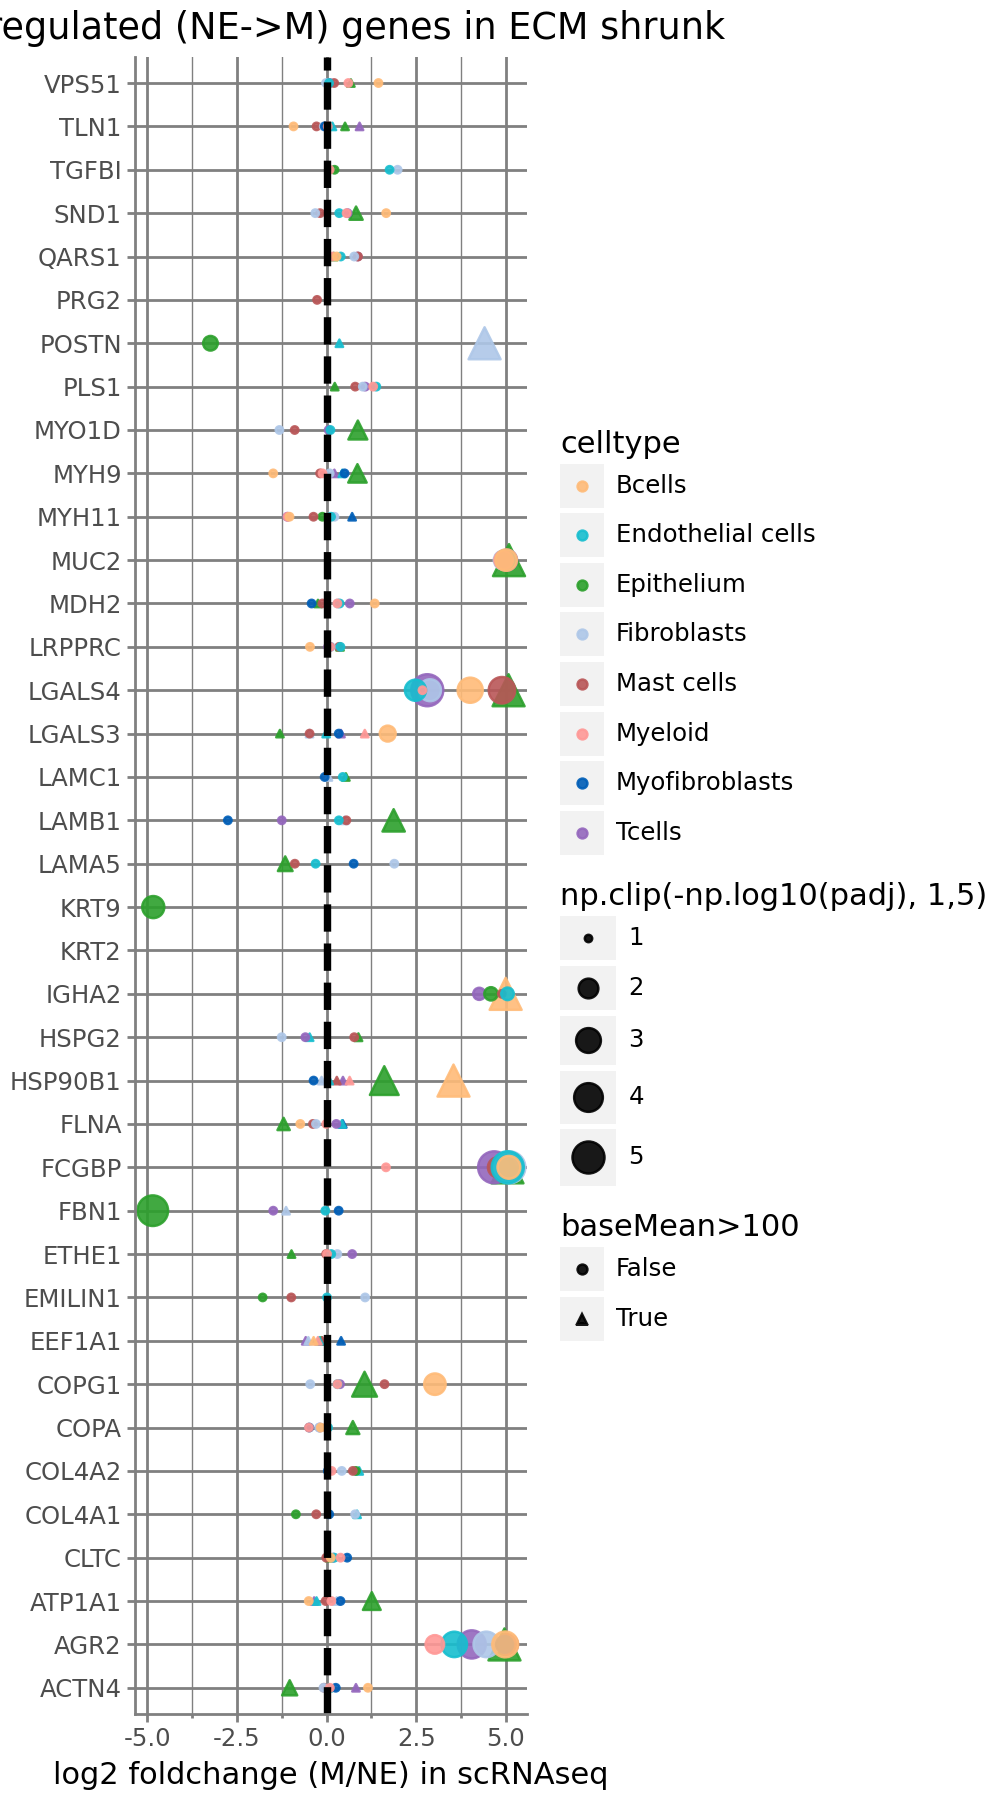

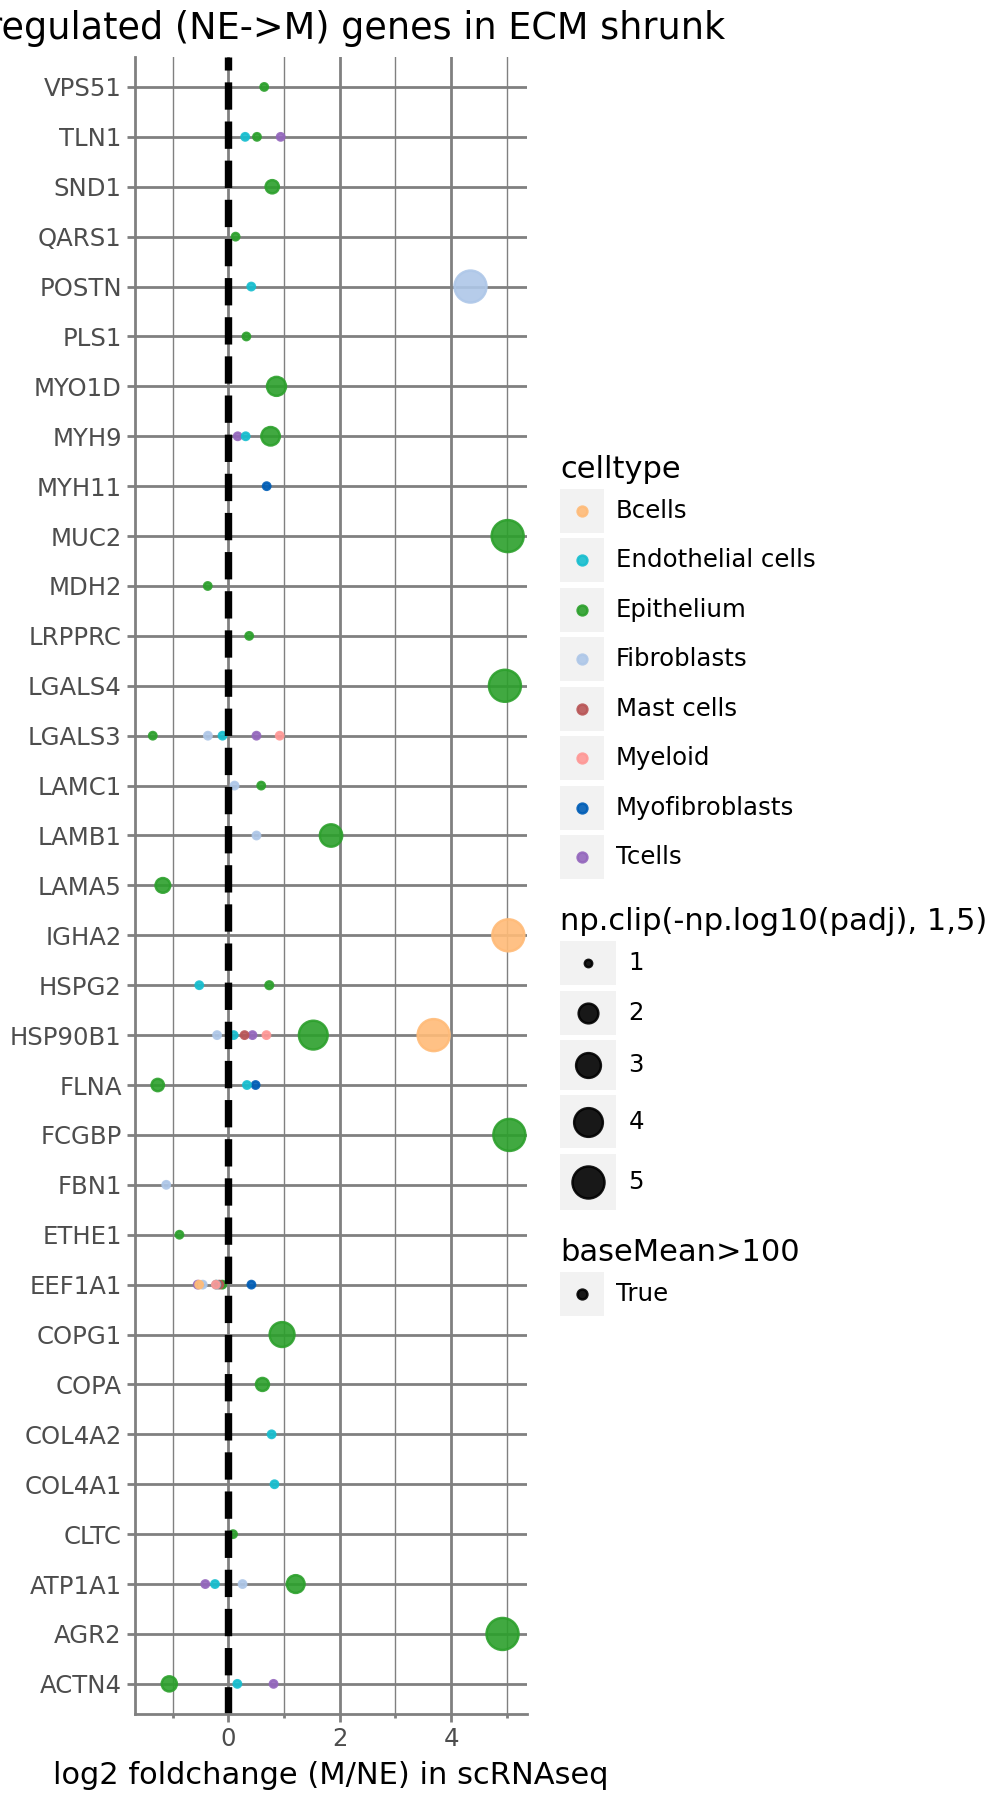

(None, None)

In [72]:
p = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_diag_unshrunk.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_diag_unshrunk_baseMean.svg')

p.show(), p2.show()

In [73]:
df_de_all.loc['POSTN']

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
POSTN   17.635878        3.155545  1.256018  2.512341  1.199332e-02   
POSTN  455.611773       -4.306532  0.700058 -6.151677  7.666810e-10   
POSTN    1.198657        0.112993  2.062808  0.054776  9.563168e-01   
POSTN  479.767288       -0.397787  0.706673 -0.562902  5.735018e-01   
POSTN    1.055932       -1.543927  2.078325 -0.742871  4.575598e-01   

               padj  log2FoldChange_shrunk  lfcSE_shrunk           celltype  \
POSTN  4.505532e-02           2.223489e-06      0.001978         Epithelium   
POSTN  6.398209e-07          -4.061702e+00      0.744688        Fibroblasts   
POSTN           NaN           2.848505e-08      0.001544     Myofibroblasts   
POSTN  9.999249e-01          -8.102141e-07      0.001233  Endothelial cells   
POSTN           NaN          -1.399506e-01      0.664112             Bcells   

      independent_filter  
POSTN                 ok  
POSTN                 ok  
POSTN           filtered  
POSTN                 ok  
POSTN           filtered

In [74]:
from ecm_tools import plot_gene

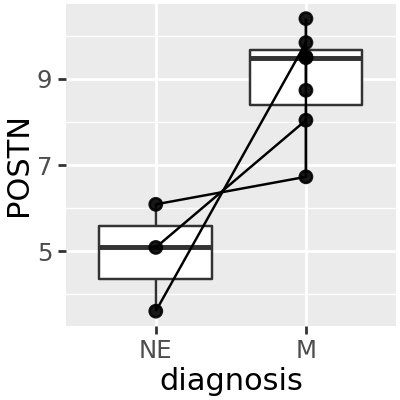

In [75]:
gene = 'POSTN'
ct = 'Fibroblasts'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

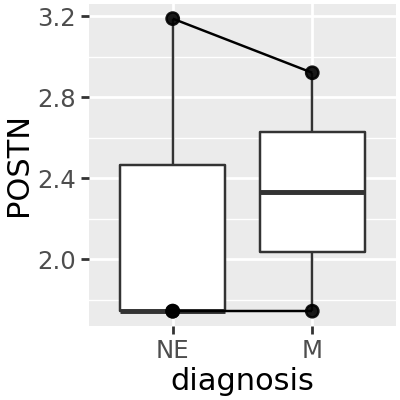

In [76]:
ct = 'Myofibroblasts'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

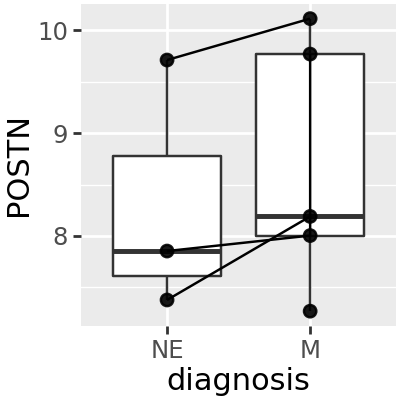

In [77]:
ct = 'Endothelial cells'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

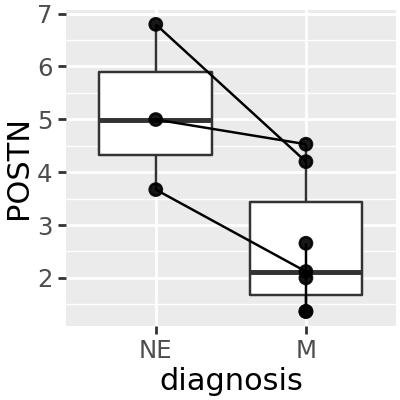

In [78]:
ct = 'Epithelium'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

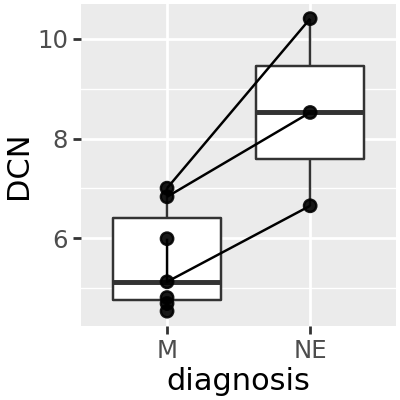

In [79]:
plot_gene('DCN', adata_vsds[ct], grouping_var='diagnosis') + pn.theme(figure_size=(2,2))